<a href="https://colab.research.google.com/github/ClaudiaMarano/Anomaly-Detection-and-Prediction/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Preprocessing Network Dataset

In questa sezione viene effettuato il preprocessing per il dataset di Network.

### Setup

Iniziamo installando e importando le librerie necessarie per il preprocessing.

In [6]:
# Installazione delle librerie mancanti (se necessario)
# !pip install pandas numpy matplotlib seaborn scikit-learn

# Importazione delle librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

### Caricamento dataset di rete

In [7]:
from google.colab import drive
import os
import ipywidgets as widgets
from IPython.display import display

# Monta Google Drive
drive.mount('/content/drive')

# Percorso di Google Drive
root_path = '/content/drive/My Drive/'

# Elenca le cartelle disponibili anella radice
folders = [name for name in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, name))]

# Crea un menu a tendina per selezionare una cartella per i file di rete
network_folder_dropdown = widgets.Dropdown(
    options=folders,
    description='Rete Folder:',
    disabled=False,
)

# Variabile globale per salvare la cartella selezionata per i file di rete
network_selected_folder = None

# Funzione per aggiornare la cartella di rete selezionata
def on_network_folder_selection(change):
    global network_selected_folder
    network_selected_folder = os.path.join(root_path, change['new'])
    print(f"Hai selezionato la cartella di rete: {network_selected_folder}")

    # Elenca i file nella cartella selezionata
    file_list = [file for file in os.listdir(network_selected_folder) if os.path.isfile(os.path.join(network_selected_folder, file))]

    if file_list:
        # Mostra i file disponibili nella cartella selezionata
        print("File disponibili nella cartella selezionata (Rete):")
        print(file_list)
    else:
        print("La cartella selezionata (Rete) non contiene file.")

# Mostra il menu a tendina per la cartella di rete
display(network_folder_dropdown)

# Assegna la funzione all'evento di selezione della cartella
network_folder_dropdown.observe(on_network_folder_selection, names='value')

Mounted at /content/drive


Dropdown(description='Rete Folder:', options=('Isi', 'Benvenuto', 'Modelli e metodi', 'Programmazione', 'Notab…

Hai selezionato la cartella di rete: /content/drive/My Drive/NetworkDataset
File disponibili nella cartella selezionata (Rete):
['attack_1.csv', 'attack_2.csv', 'attack_3.csv', 'attack_4.csv', 'normal.csv', 'processed_normal_resampled.csv', 'processed_attack_1_resampled.csv', 'processed_attack_2_resampled.csv', 'processed_attack_3_resampled.csv', 'processed_attack_4_resampled.csv']


### Creazione funzione di preprocessing

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_and_resample(file_path, output_path, time_column='Time', resample_interval='1s', plot_data=True, label="Dataset"):
    """
    Preprocessa il dataset, effettua un resampling e opzionalmente genera plot delle feature.

    Parameters:
    - file_path (str): Percorso al file CSV da preprocessare.
    - output_path (str): Percorso dove salvare il file preprocessato e resamplato.
    - time_column (str): Nome della colonna temporale.
    - resample_interval (str): Intervallo di resampling (es. '30s', '1min').
    - plot_data (bool): Se True, genera i plot delle feature resamplate.
    - label (str): Etichetta per identificare il dataset nei grafici.
    """
    # Carica il dataset
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()

    # Controlla se la colonna temporale esiste
    if time_column not in df.columns:
        raise ValueError(f"La colonna temporale '{time_column}' non è presente nel dataset.")

    # Converte la colonna temporale in datetime
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce')

    # Preprocessing: Mantiene solo le feature rilevanti, inclusa `label_n`
    relevant_features = [
        time_column, 'ip_s', 'ip_d', 'sport', 'dport', 'proto', 'flags',
        'size', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst', 'modbus_response', 'label_n'
    ]
    relevant_features = [col for col in relevant_features if col in df.columns]  # Filtra solo le colonne presenti
    df = df[relevant_features]

    # Resampling
    df_resampled = df.set_index(time_column).resample(resample_interval).agg({
        'ip_s': 'nunique',  # Numero unico di IP sorgente
        'ip_d': 'nunique',  # Numero unico di IP destinazione
        'sport': 'nunique',  # Numero unico di porte sorgente
        'dport': 'nunique',  # Numero unico di porte destinazione
        'proto': 'nunique',  # Numero unico di protocolli
        'flags': 'nunique',  # Numero unico di flags
        'size': ['mean', 'sum', 'std'],  # Statistiche sulla dimensione
        'modbus_fn': 'count',  # Conteggio richieste Modbus
        'n_pkt_src': 'sum',  # Totale pacchetti inviati
        'n_pkt_dst': 'sum',  # Totale pacchetti ricevuti
        'modbus_response': 'count',  # Conteggio risposte Modbus
        'label_n': 'max'  # Se almeno un dato ha label_n=1, assegna 1
    }).fillna(0)

    # Rinomina le colonne
    df_resampled.columns = [
        'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count',
        'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std',
        'modbus_request_count', 'total_packets_sent', 'total_packets_received', 'modbus_response_count',
        'label_n'
    ]

    # Salva il dataset preprocessato
    df_resampled.to_csv(output_path)
    print(f"Dataset resample salvato in: {output_path}")

    # Genera i plot se richiesto
    if plot_data:
        for column in df_resampled.columns:
            if column != 'label_n':  # Non plottare `label_n`
                plt.figure(figsize=(12, 6))
                plt.plot(df_resampled.index, df_resampled[column], label=f"{label}: {column}")
                plt.title(f"{column} nel tempo ({resample_interval})")
                plt.xlabel("Time")
                plt.ylabel(column)
                plt.legend()
                plt.grid()
                plt.show()
    return df_resampled

### Esecuzione del preprocessing

Eseguiamo il preprocessing per il file normal.csv

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_normal_resampled.csv


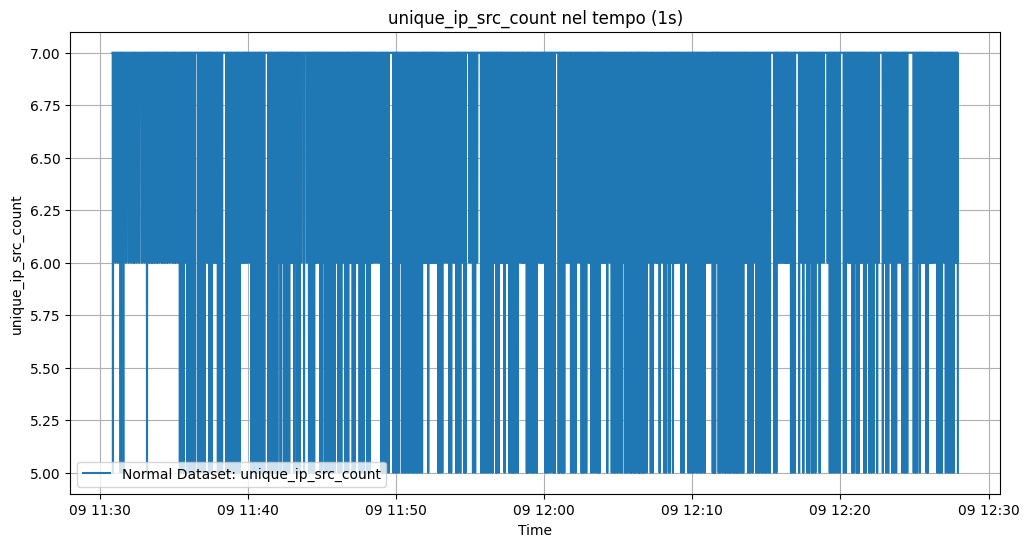

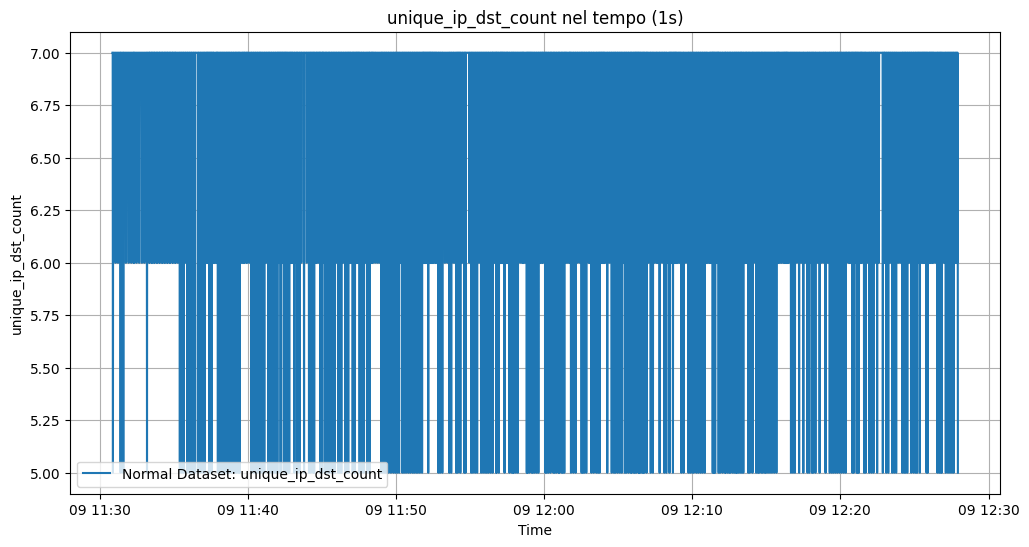

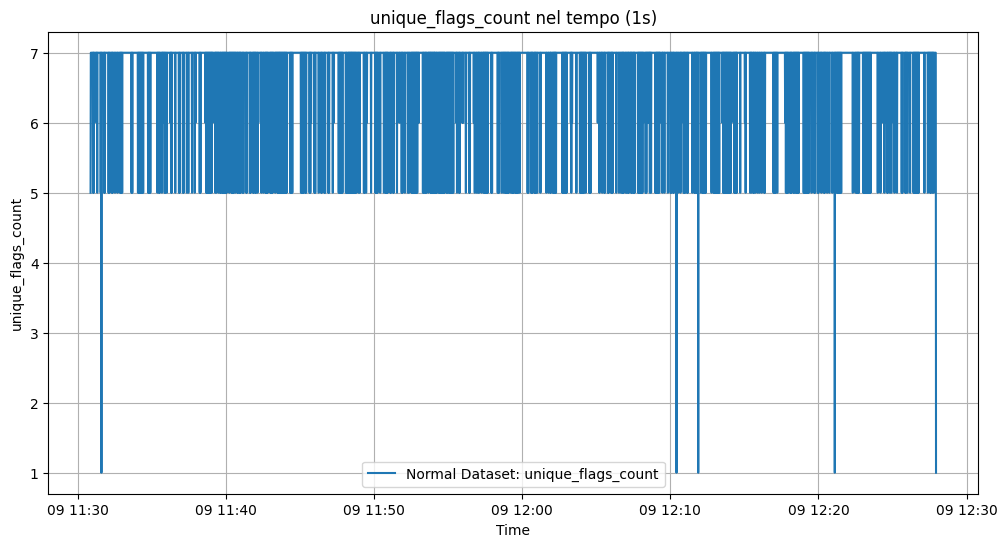

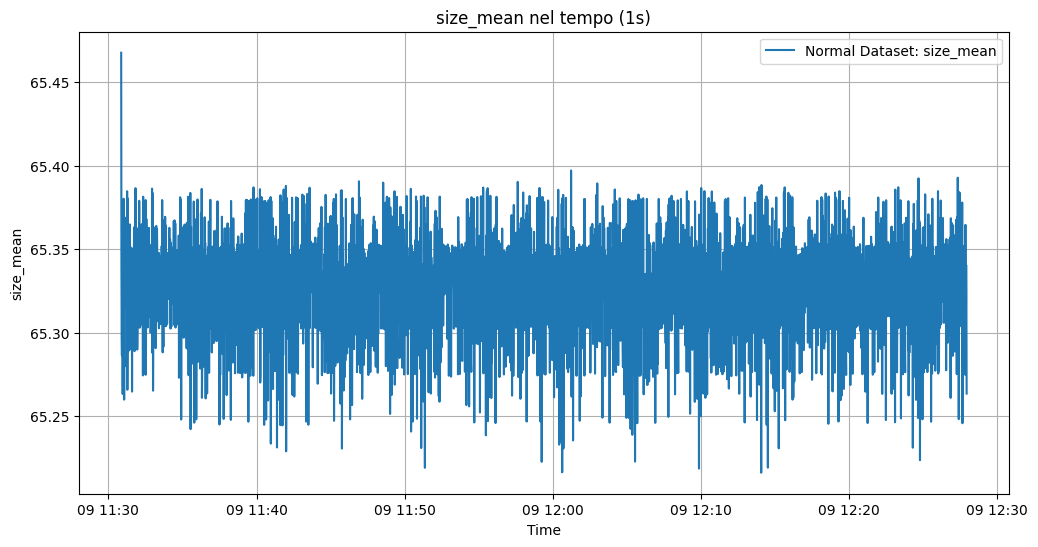

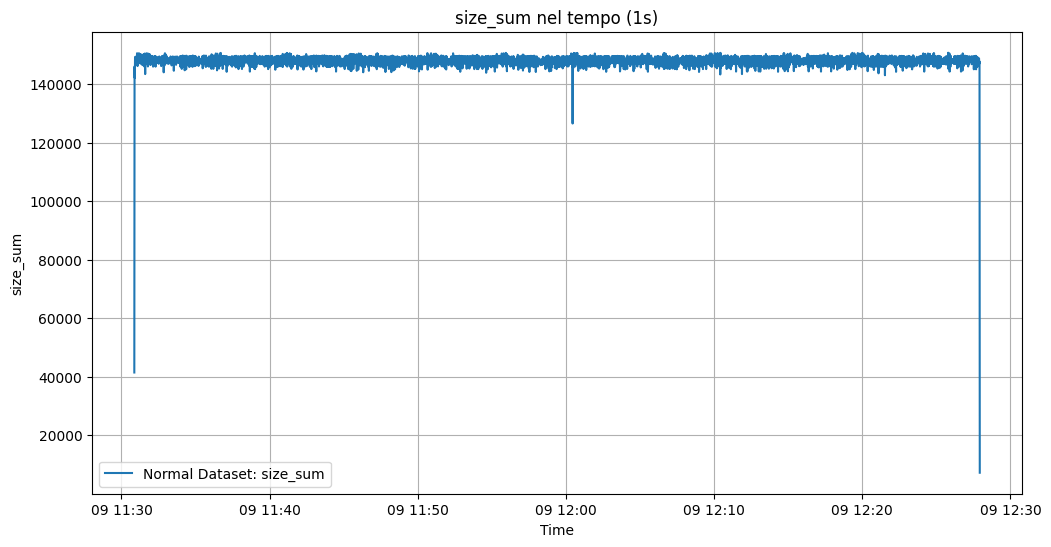

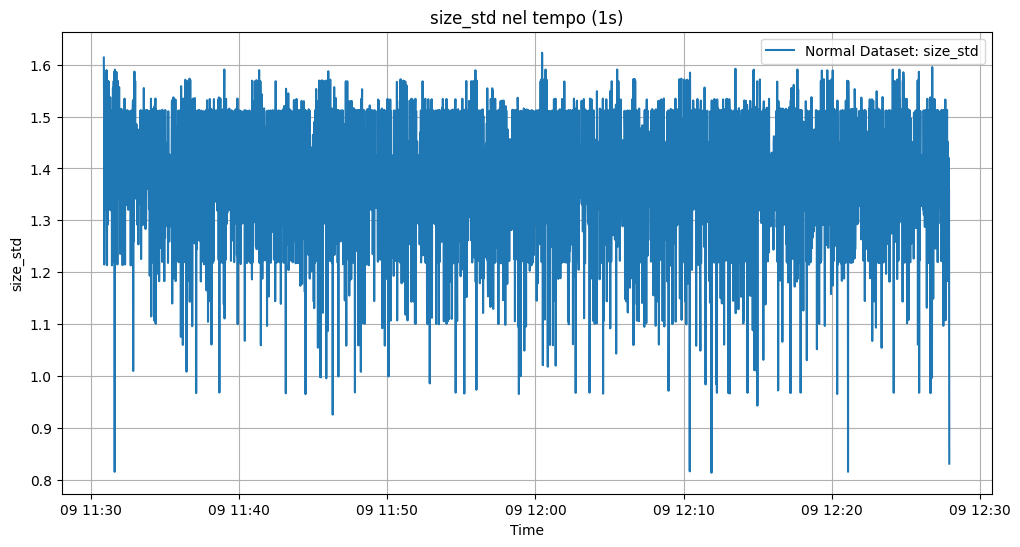

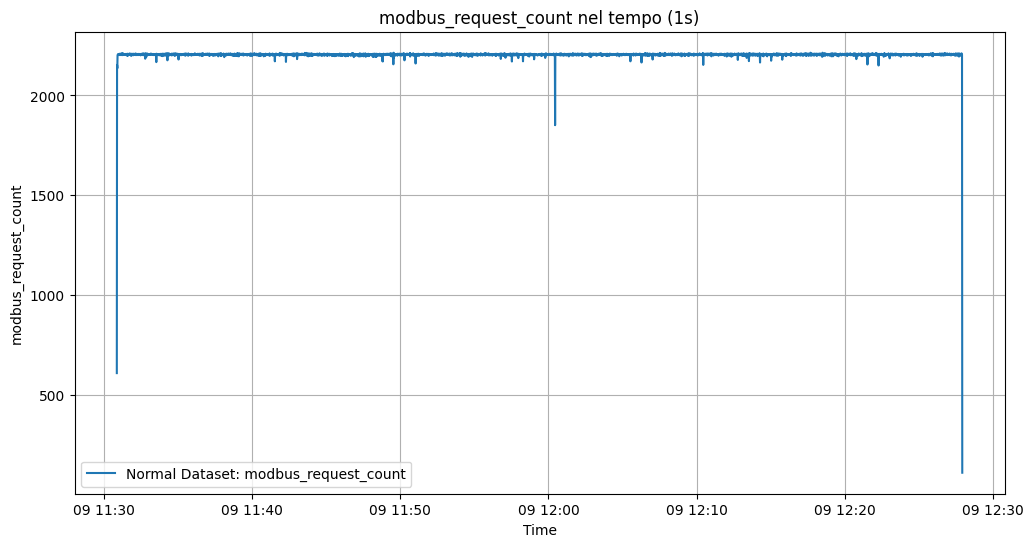

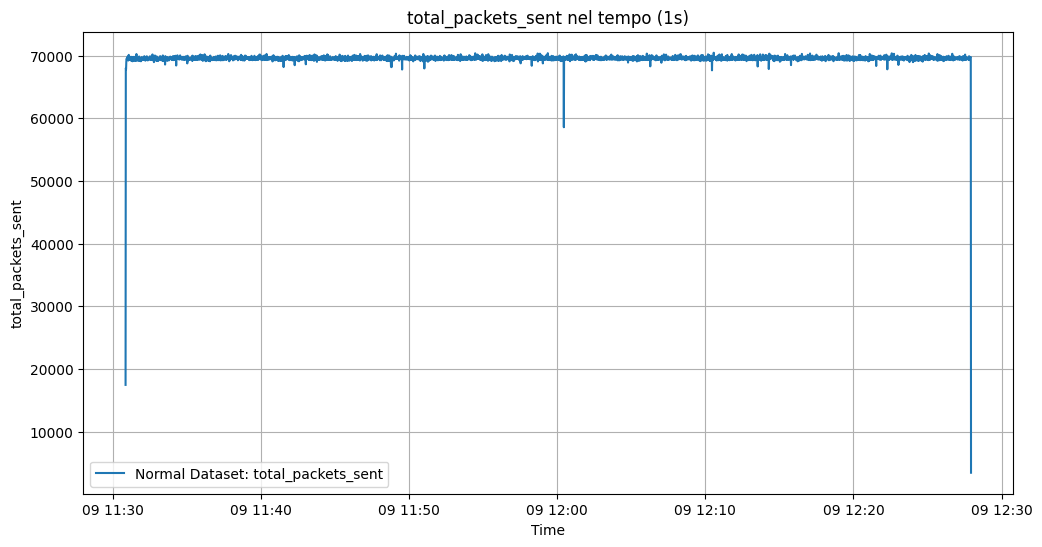

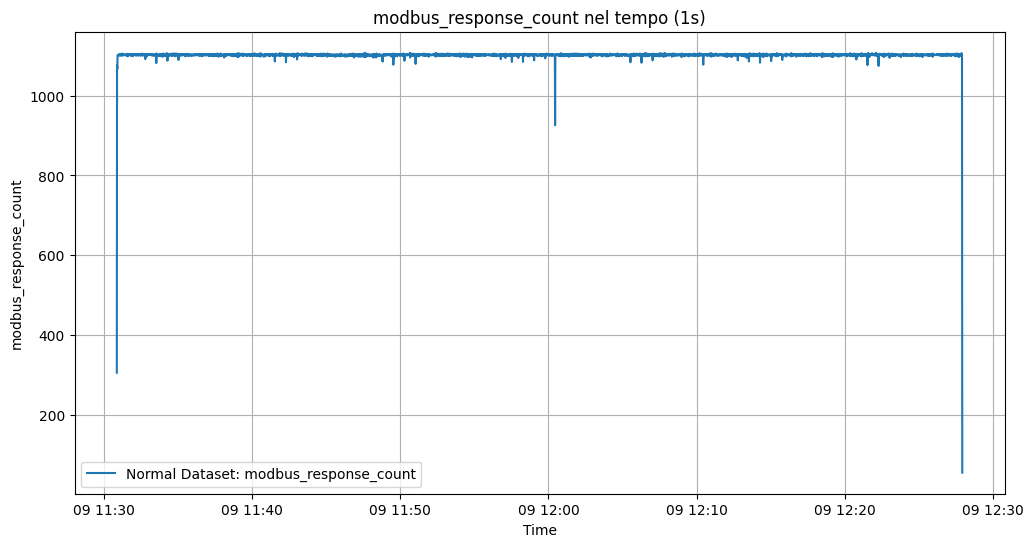

In [9]:
# Dataset normale
normal_file = os.path.join(network_selected_folder, 'normal.csv')  # File selezionato
normal_output = os.path.join(network_selected_folder, 'processed_normal_resampled.csv')  # Percorso di output

# Preprocessa il dataset normale
normal_resampled = preprocess_and_resample(
    file_path=normal_file,
    output_path=normal_output,
    time_column='Time',
    resample_interval='1s',
    plot_data=True,
    label="Normal Dataset"
)

Esecuzione del preprocessing per i file di attacco.

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_1_resampled.csv


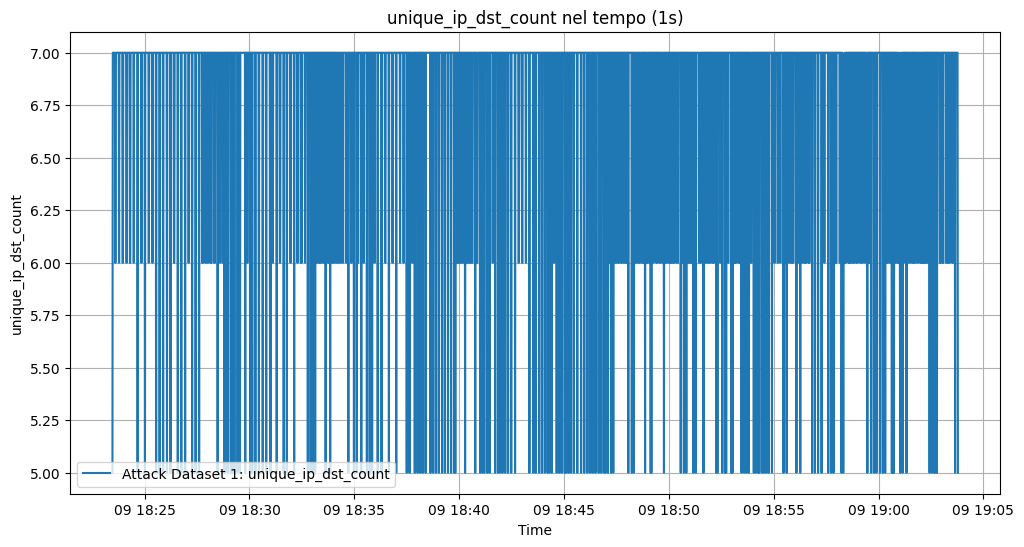

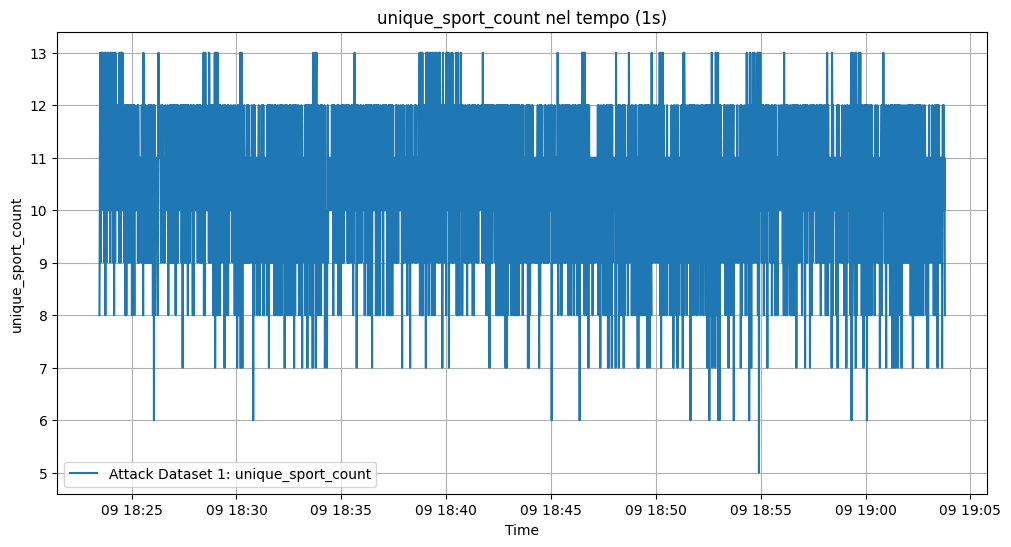

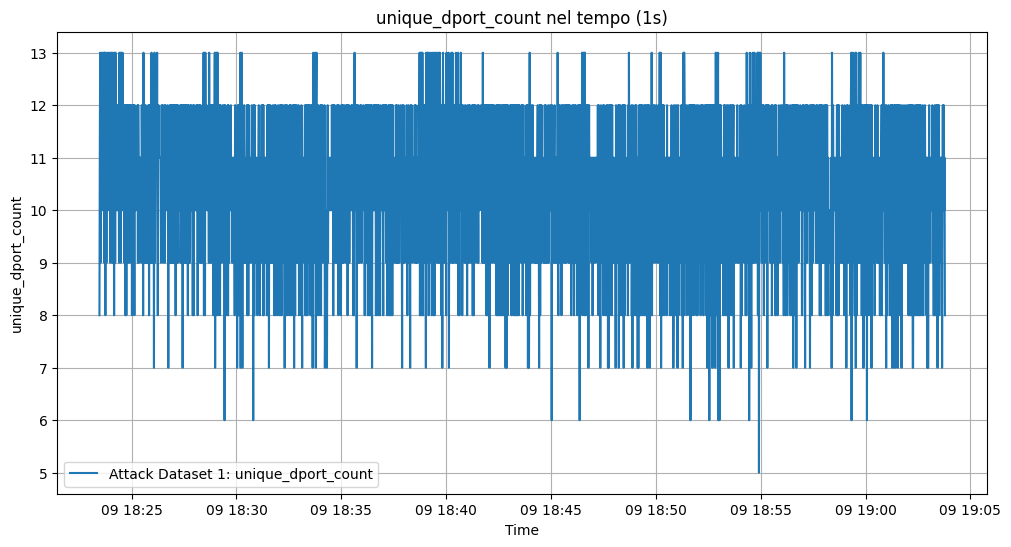

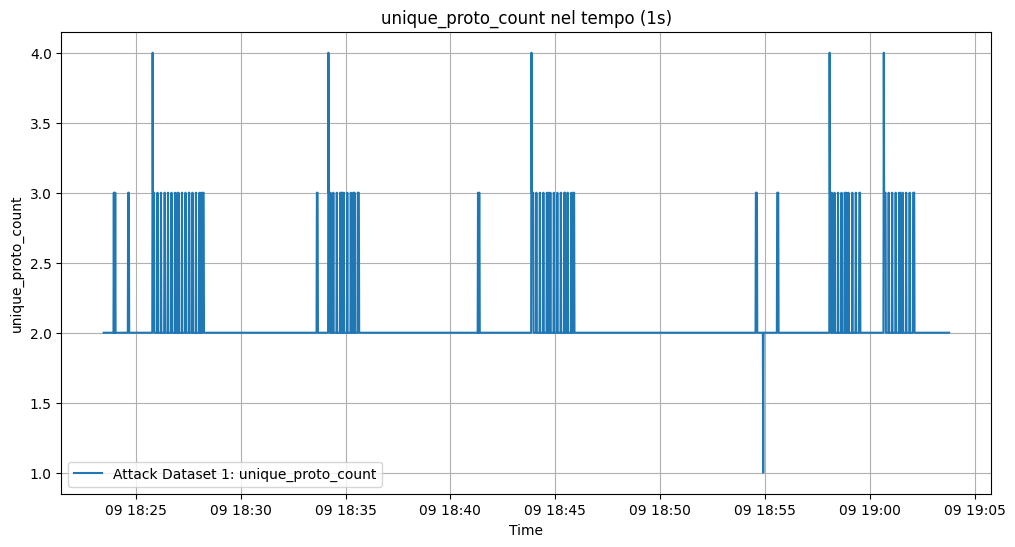

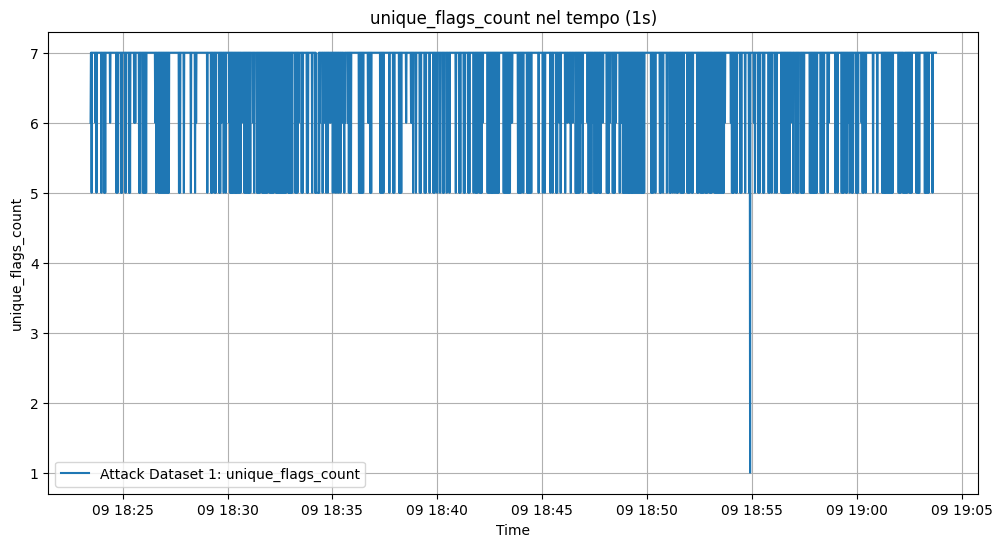

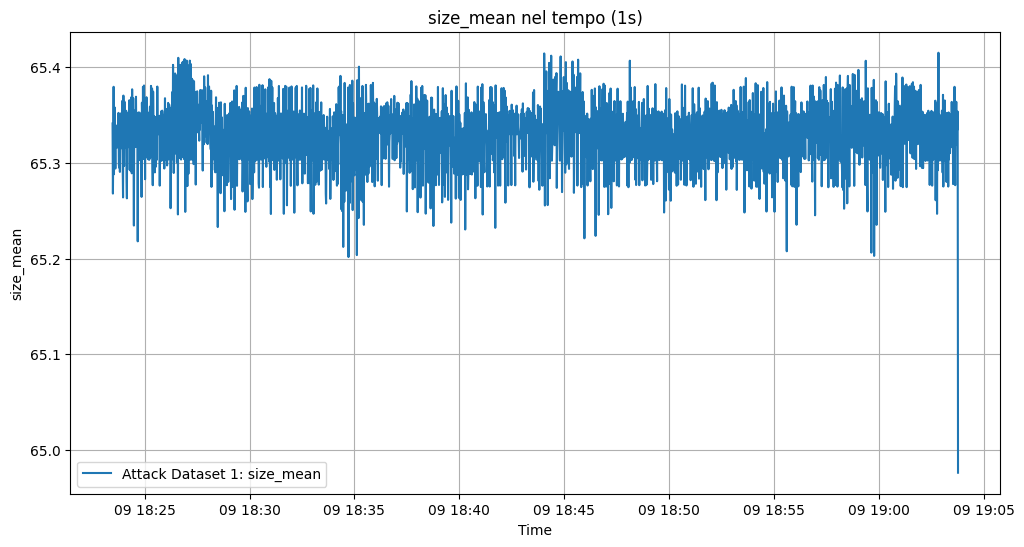

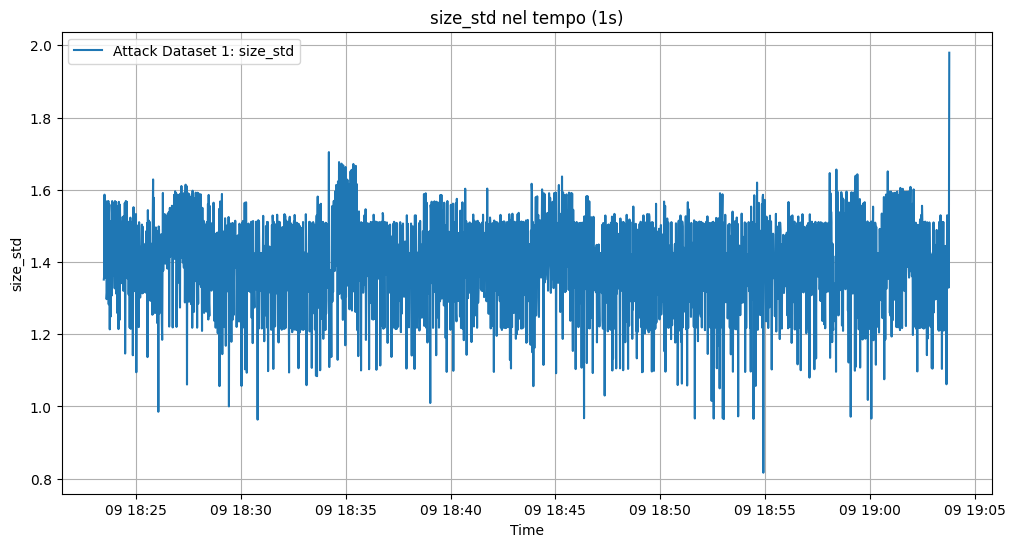

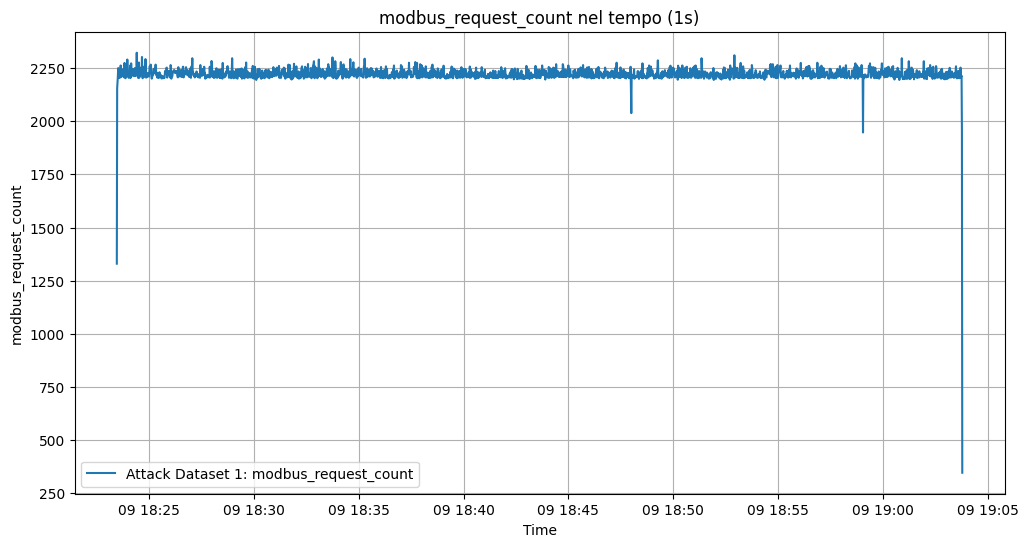

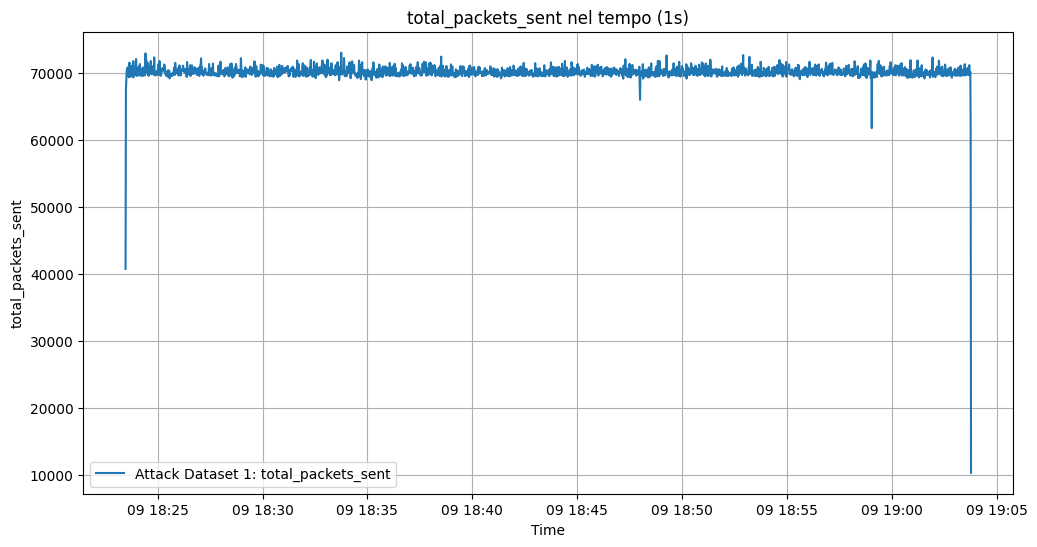

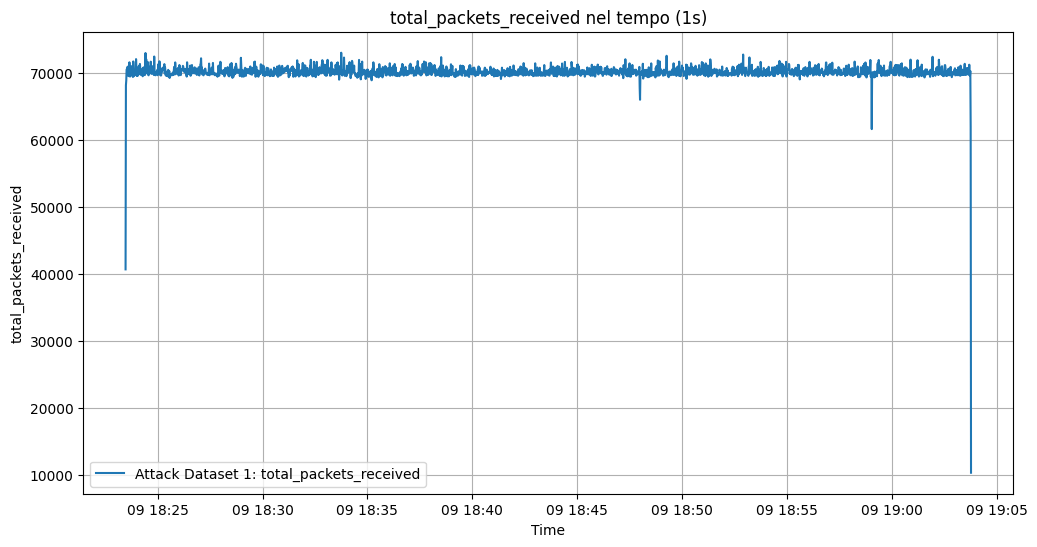

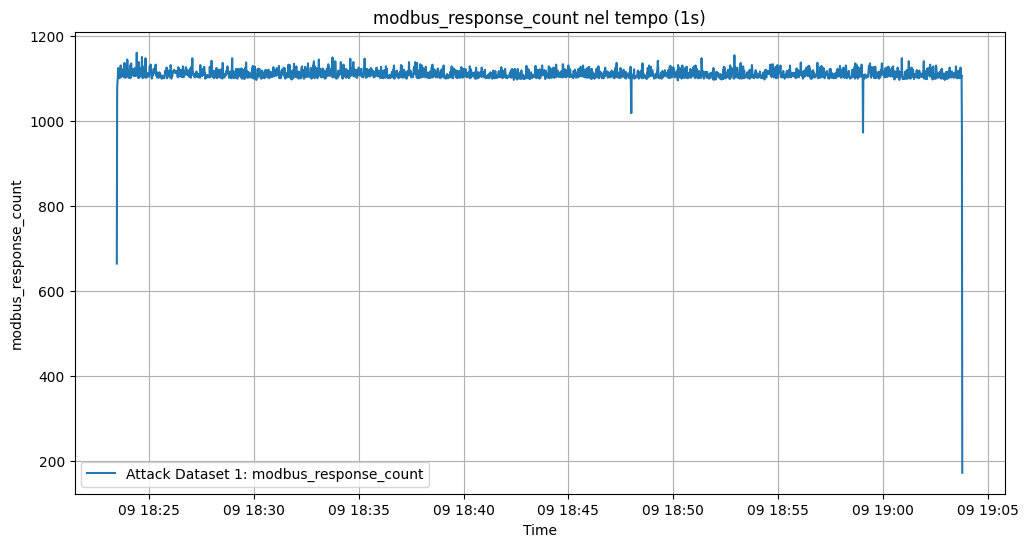

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_2_resampled.csv


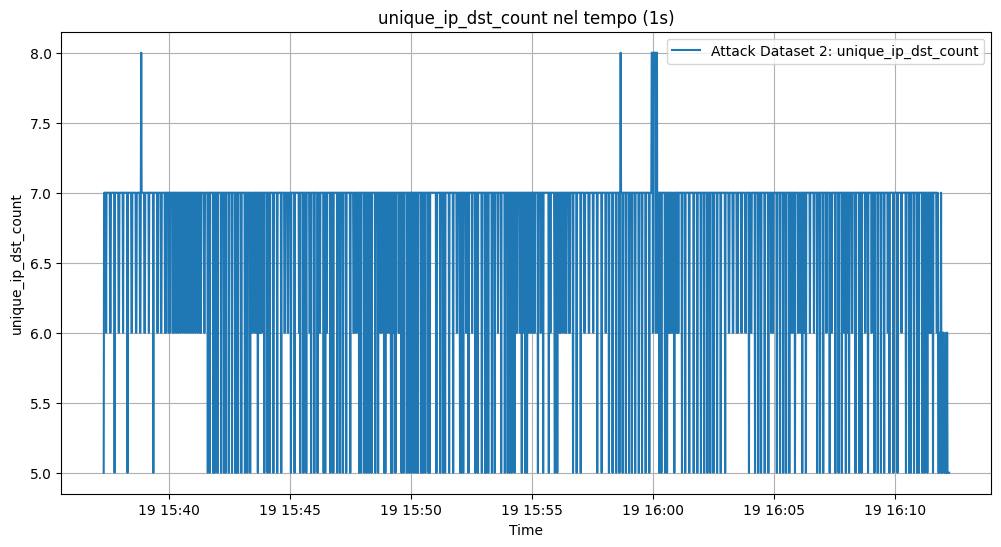

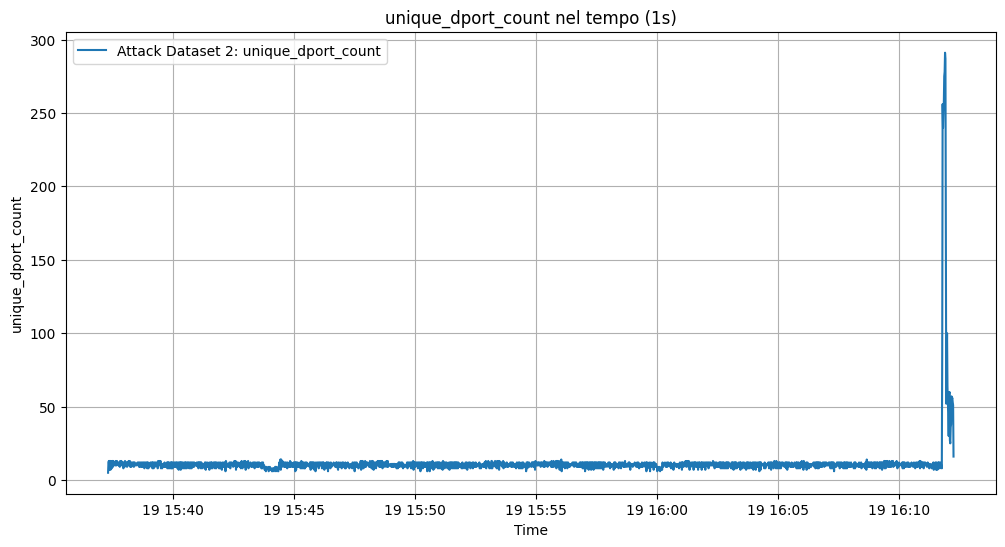

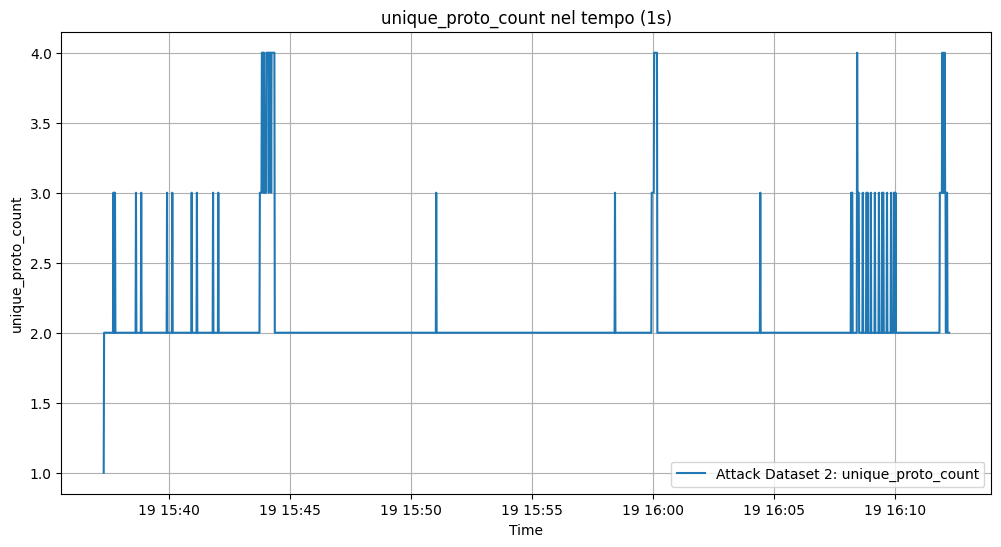

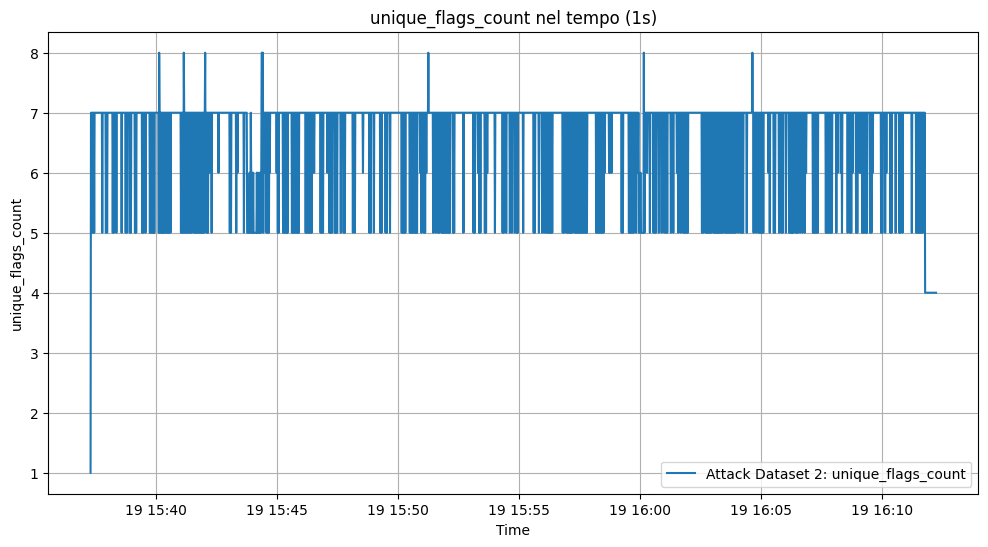

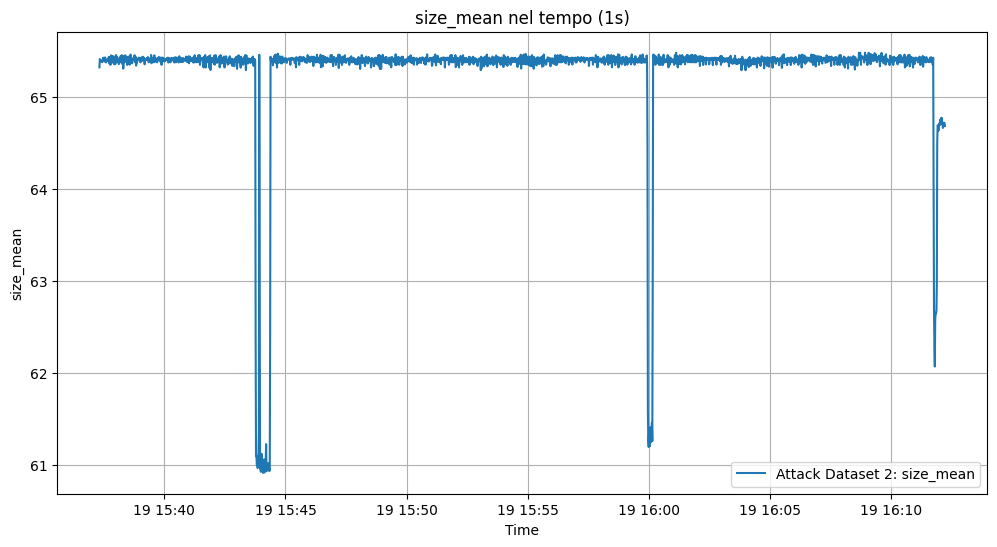

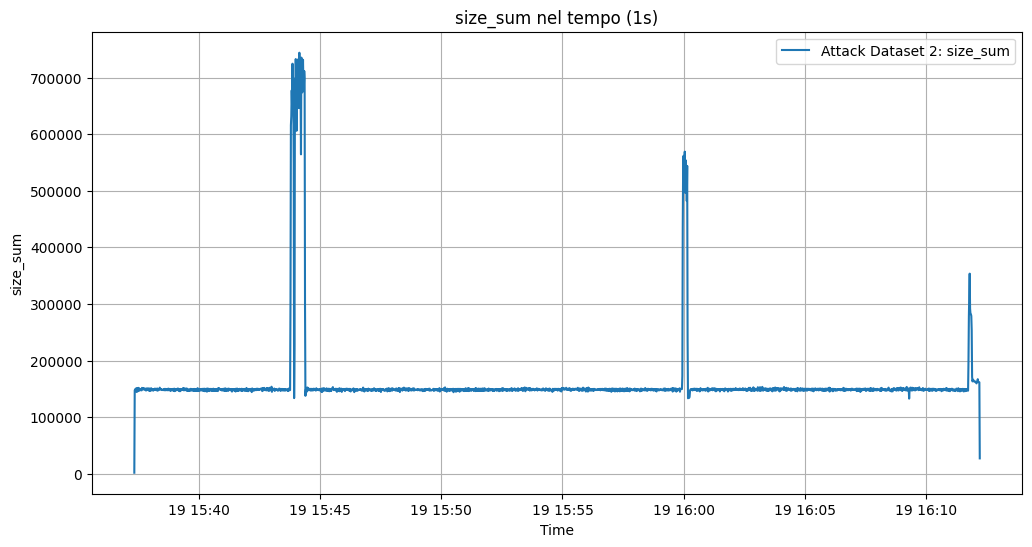

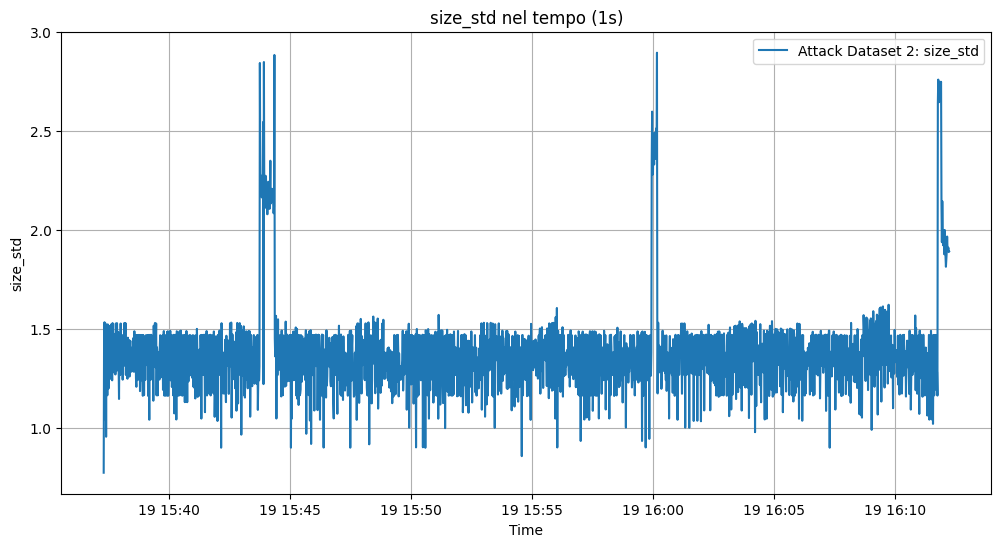

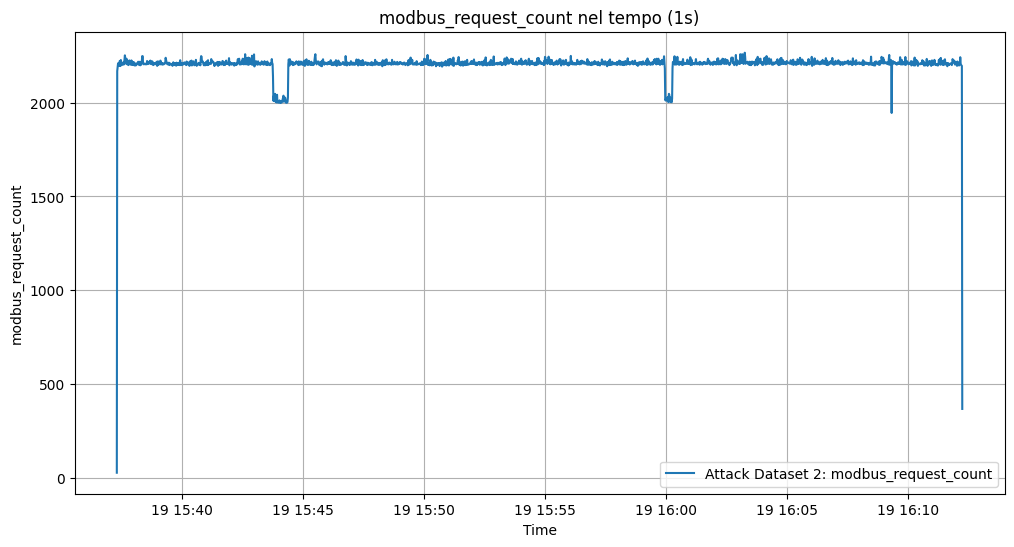

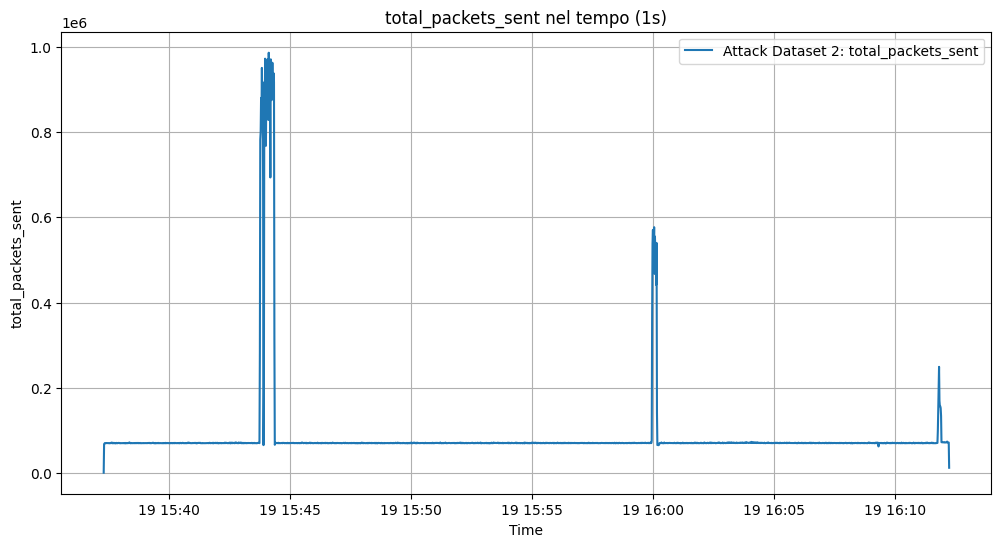

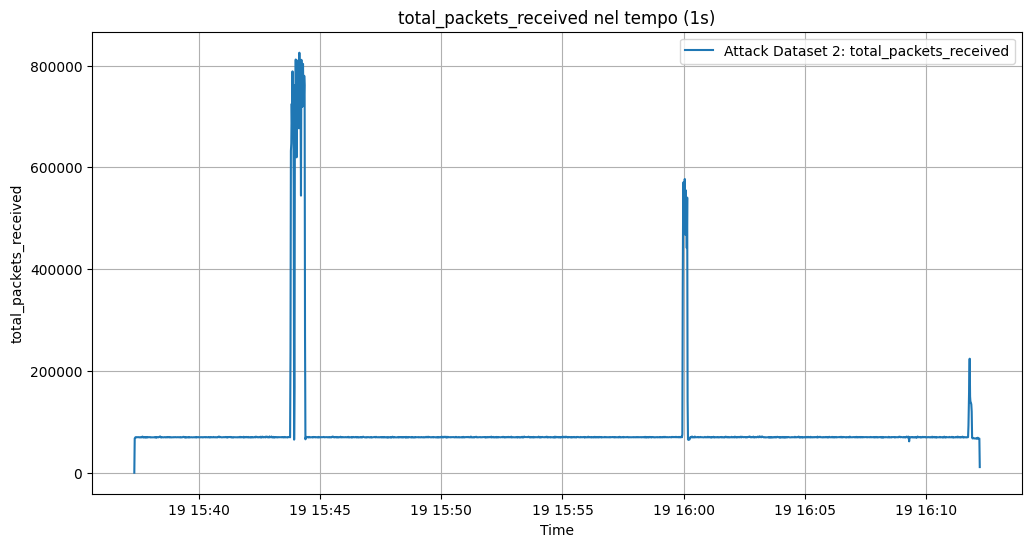

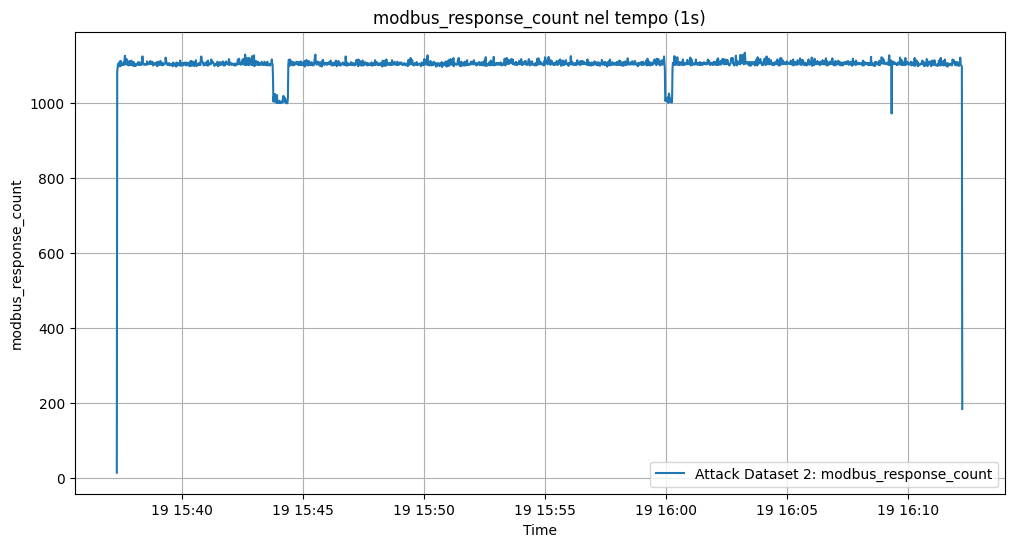

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_3_resampled.csv


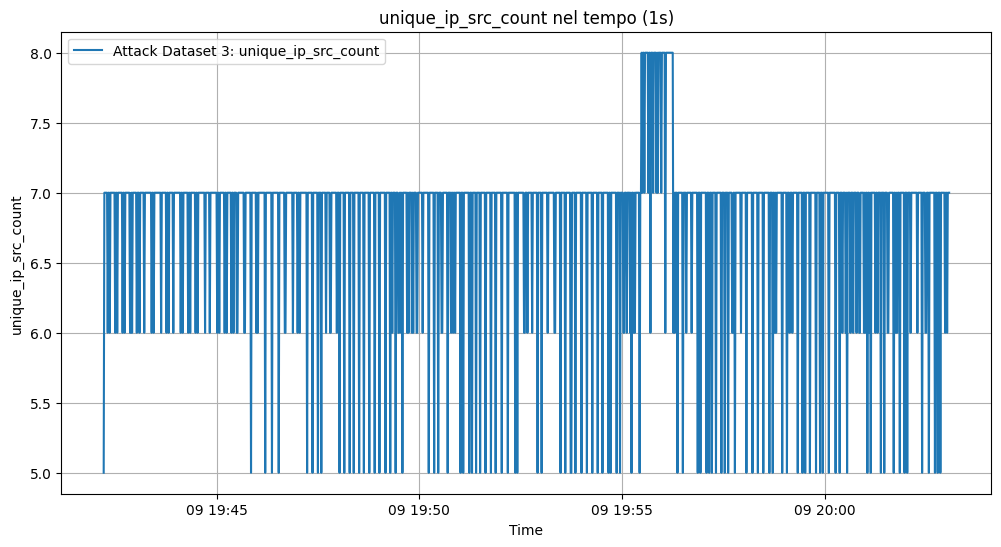

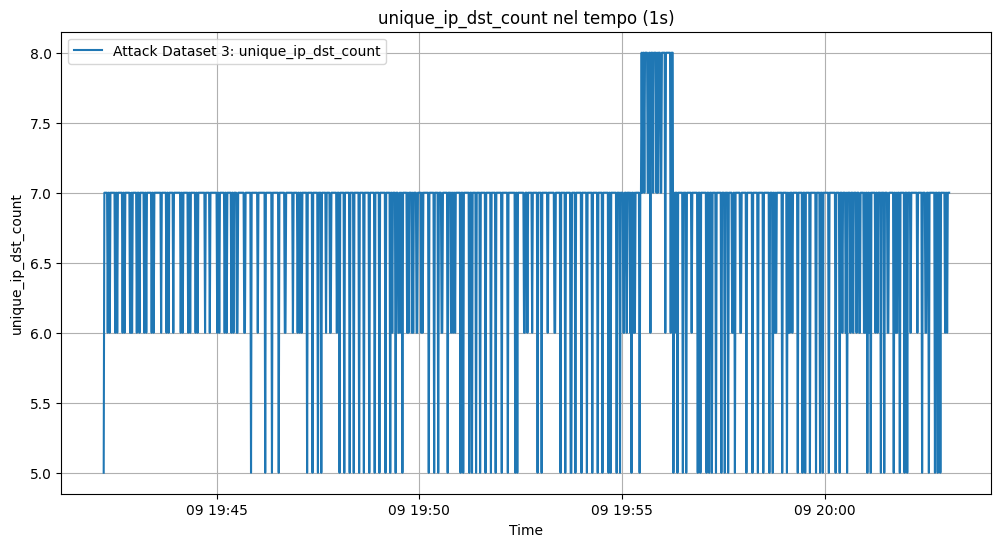

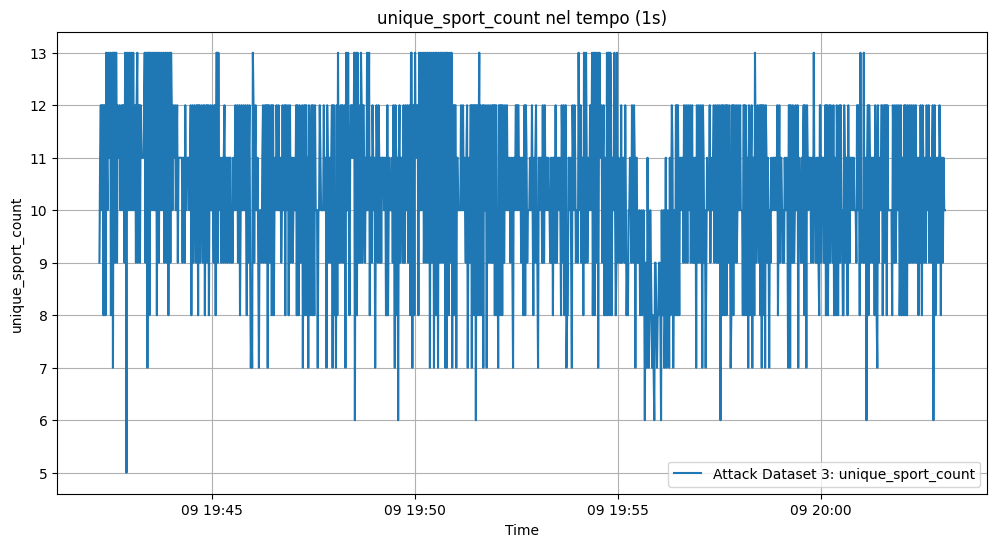

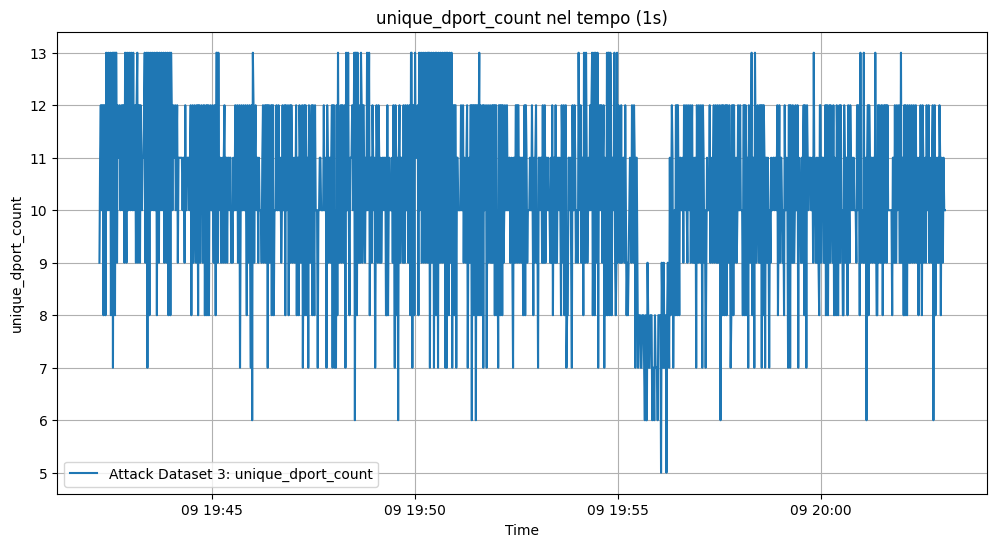

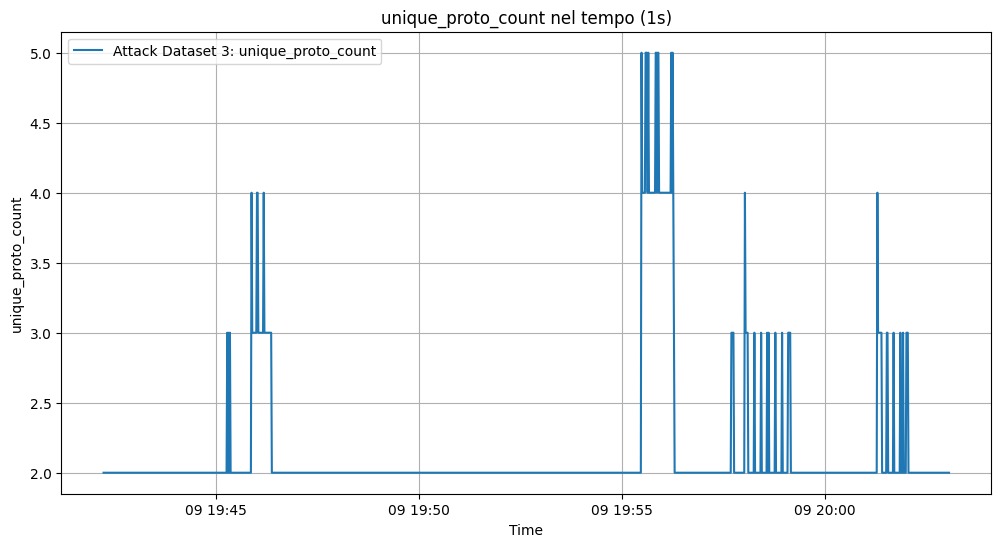

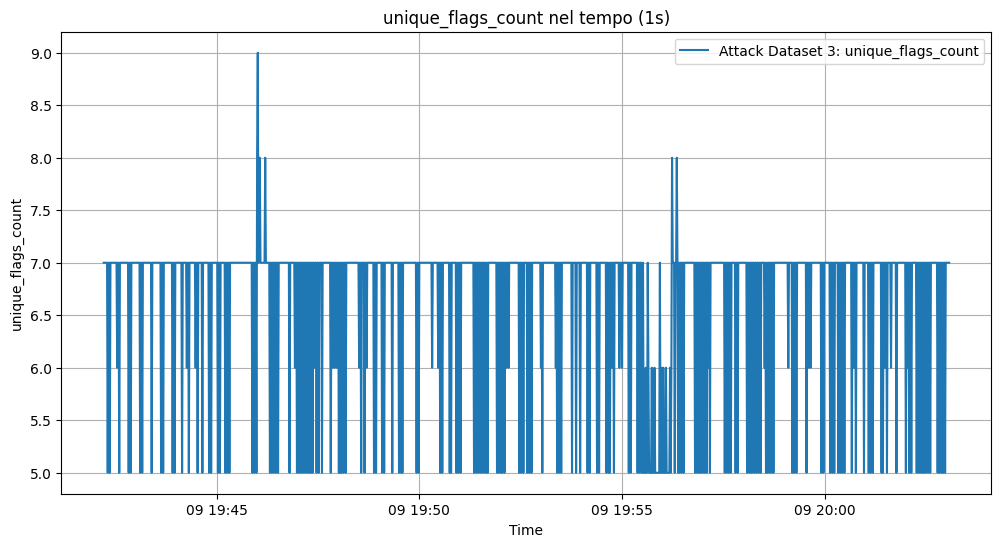

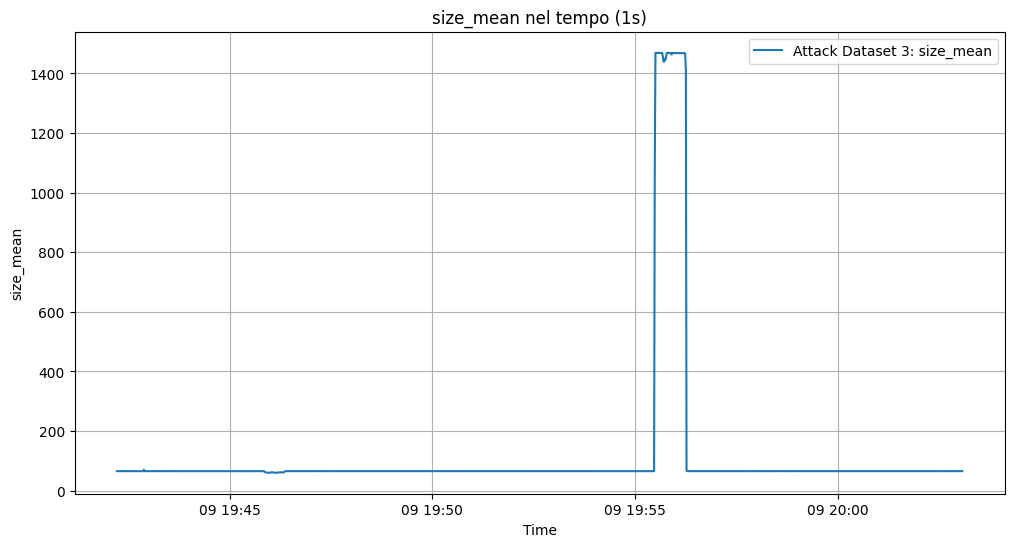

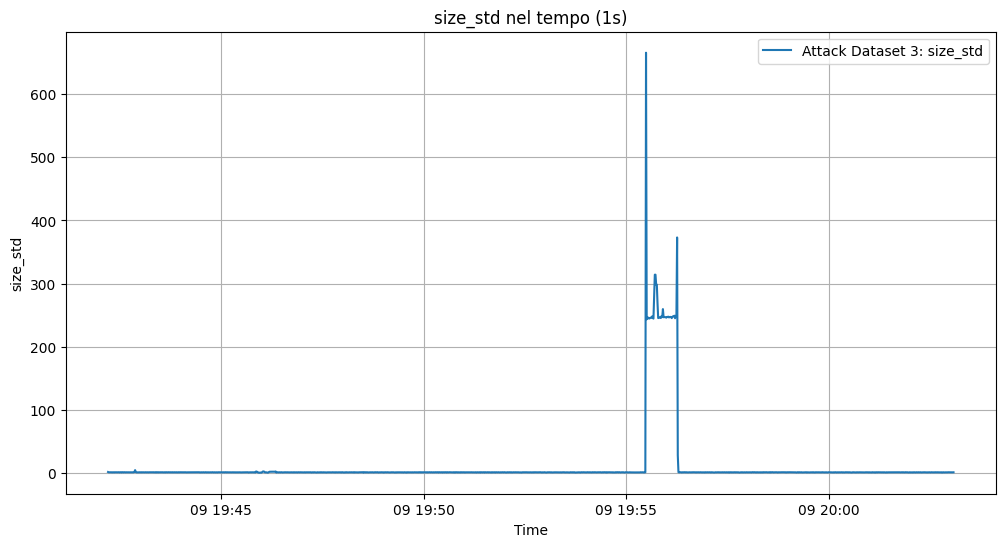

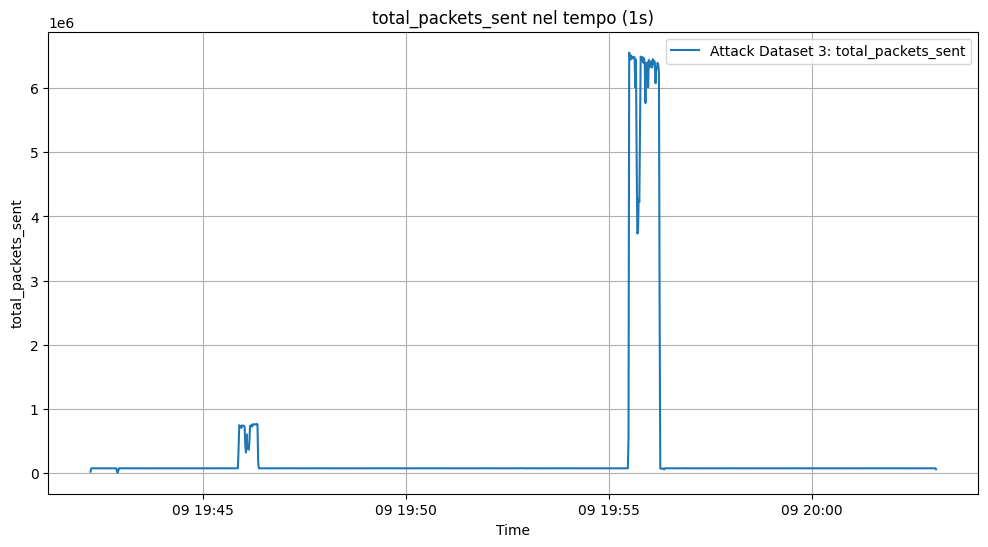

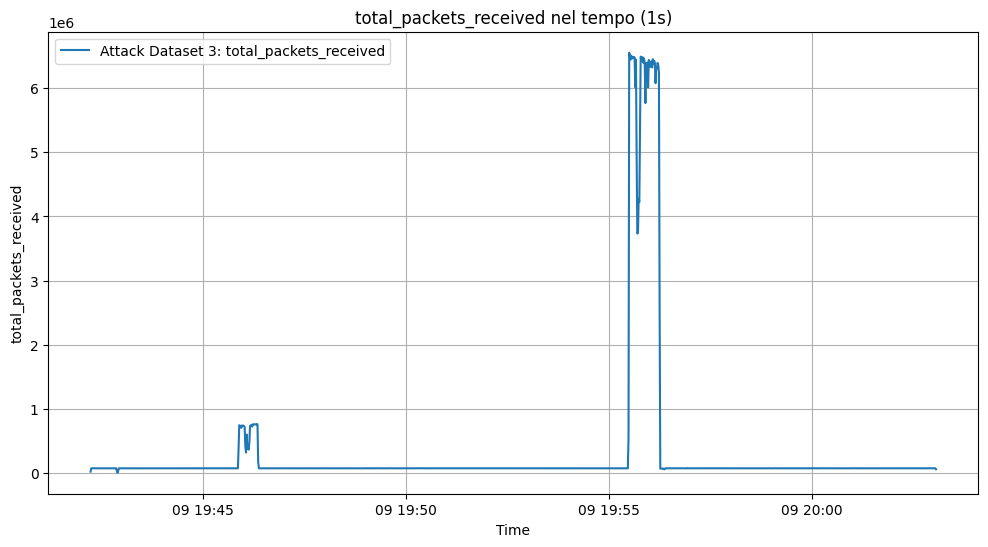

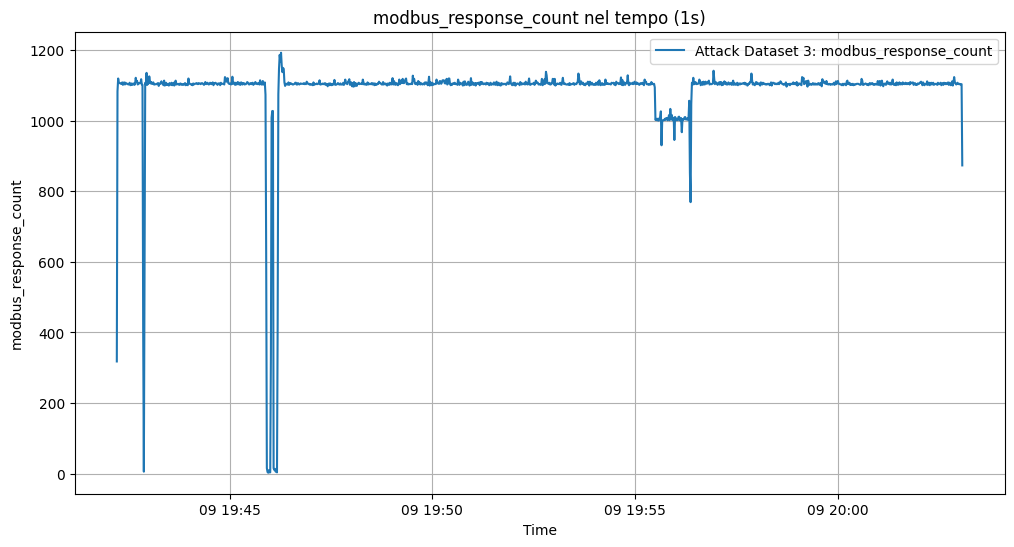

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_4_resampled.csv


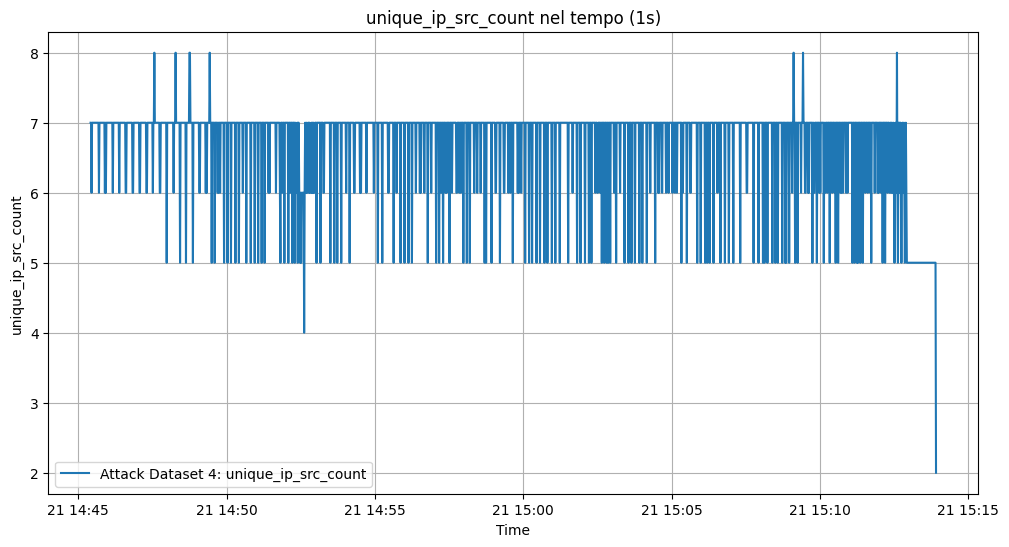

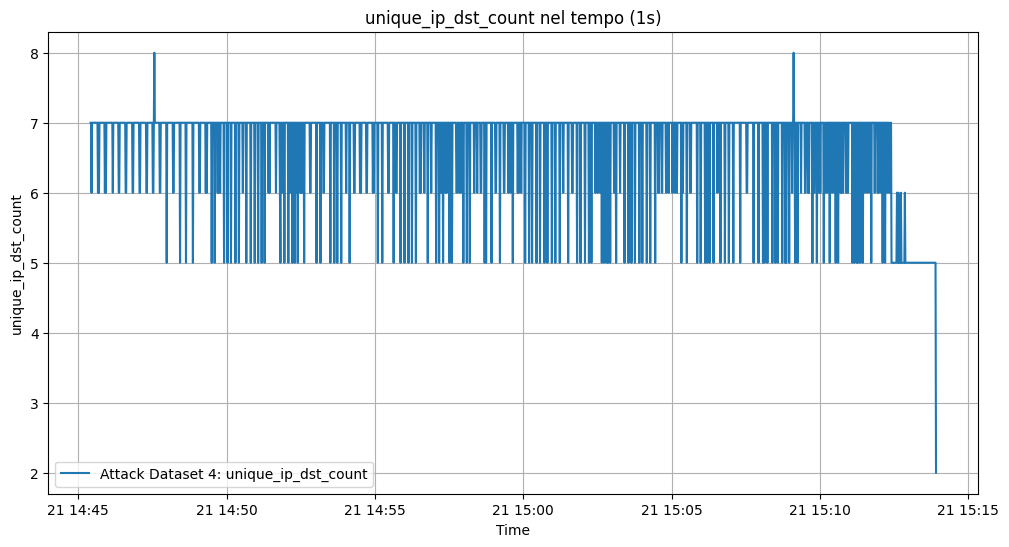

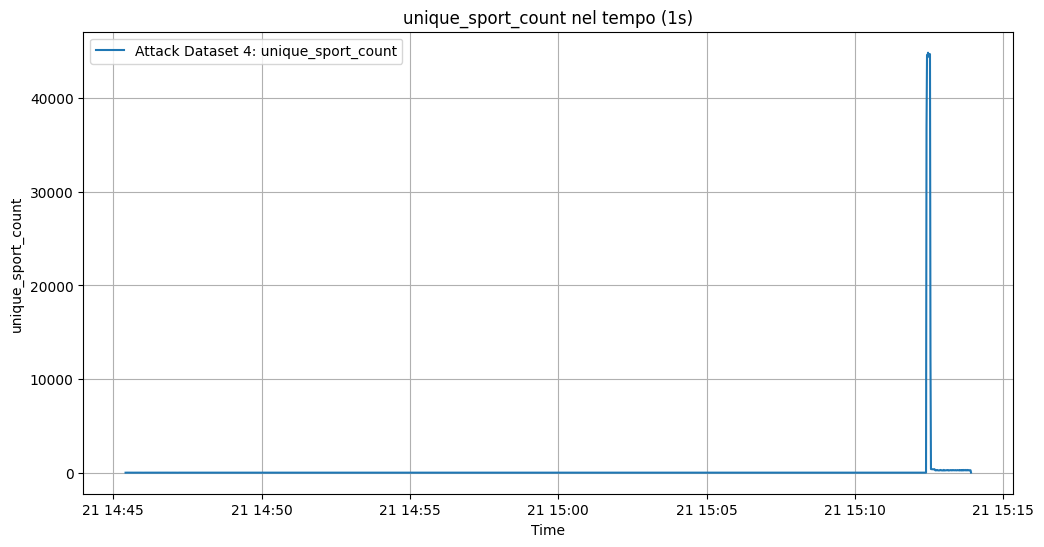

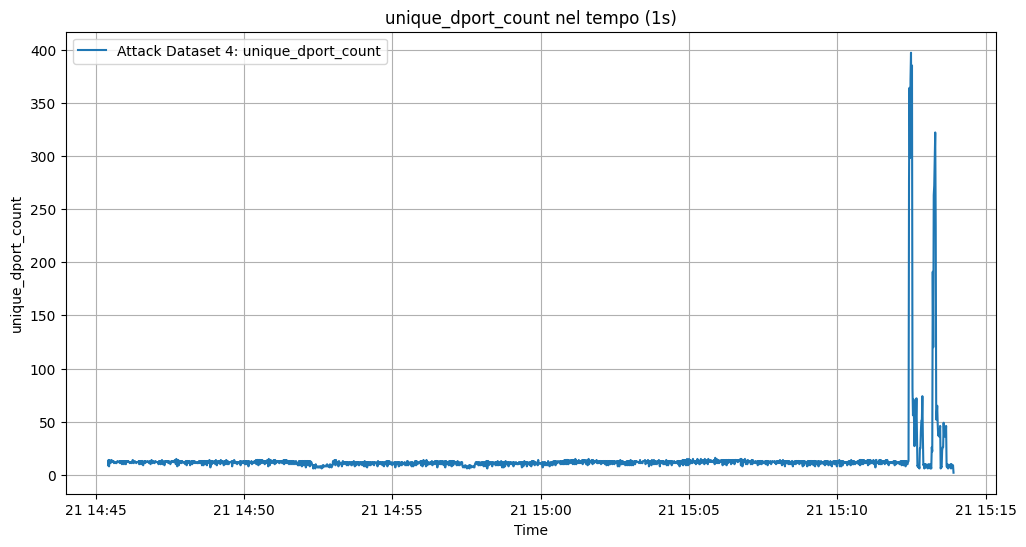

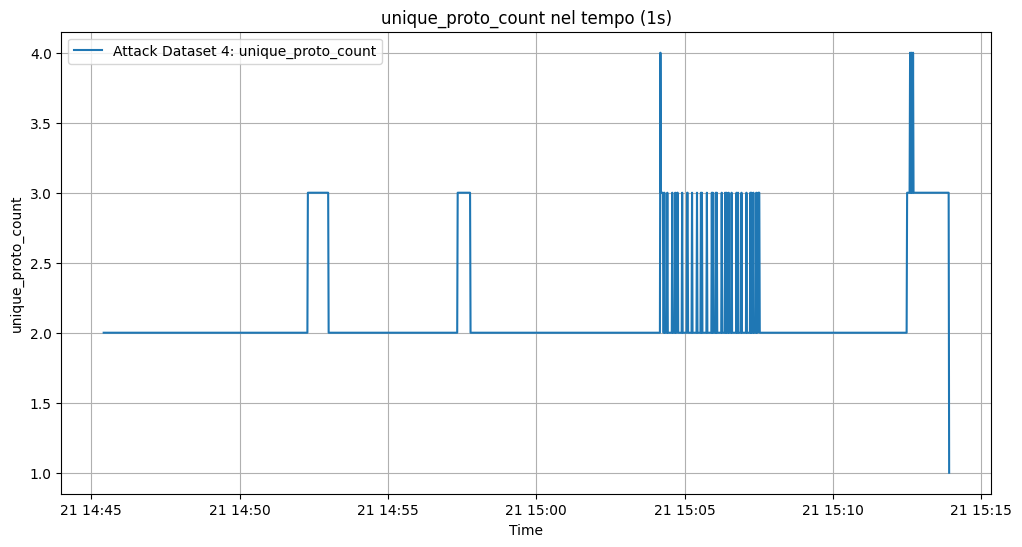

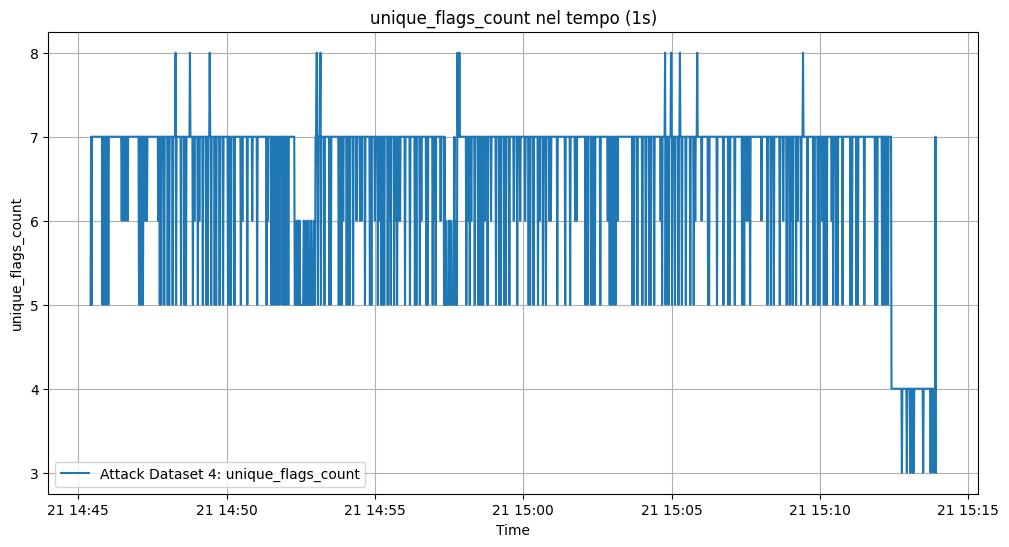

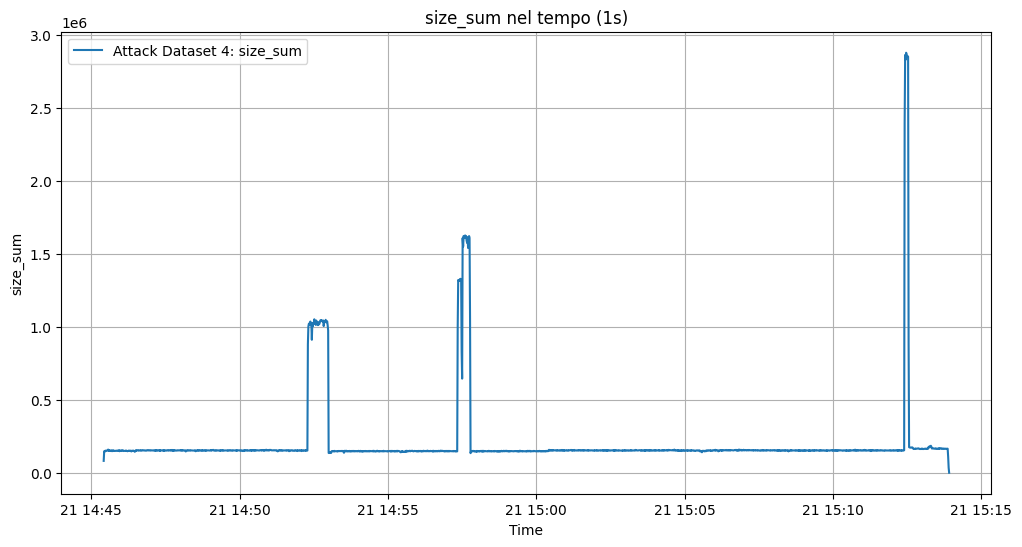

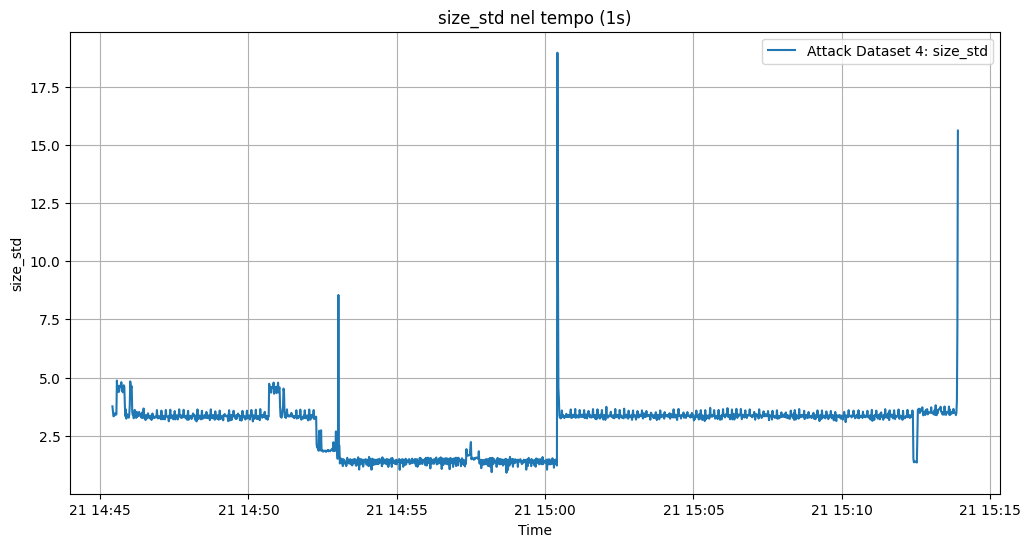

In [10]:
# Dataset di attacco
attack_files = [  # Sostituisci con i file selezionati
    os.path.join(network_selected_folder, 'attack_1.csv'),
    os.path.join(network_selected_folder, 'attack_2.csv'),
    os.path.join(network_selected_folder, 'attack_3.csv'),
    os.path.join(network_selected_folder, 'attack_4.csv')
]

# Preprocessing per ogni file di attacco
for idx, file_path in enumerate(attack_files, start=1):
    attack_output = os.path.join(network_selected_folder, f'processed_attack_{idx}_resampled.csv')
    preprocess_and_resample(
        file_path=file_path,
        output_path=attack_output,
        time_column='Time',
        resample_interval='1s',
        plot_data=True,
        label=f"Attack Dataset {idx}"
    )

## Preprocessing Physical Dataset

### Setup

In [11]:
import pandas as pd

### Caricamento del dataset fisico

In [12]:
from google.colab import drive
import os
import ipywidgets as widgets
from IPython.display import display

# Monta Google Drive
drive.mount('/content/drive')

# Percorso di Google Drive
root_path = '/content/drive/My Drive/'

# Elenca le cartelle disponibili nella radice
folders = [name for name in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, name))]

# Crea un menu a tendina per selezionare una cartella per i file fisici
physical_folder_dropdown = widgets.Dropdown(
    options=folders,
    description='Fisico Folder:',
    disabled=False,
)

# Variabile globale per salvare la cartella selezionata per i file fisici
physical_selected_folder = None

# Funzione per aggiornare la cartella fisica selezionata
def on_physical_folder_selection(change):
    global physical_selected_folder
    physical_selected_folder = os.path.join(root_path, change['new'])
    print(f"Hai selezionato la cartella fisica: {physical_selected_folder}")

    # Elenca i file nella cartella selezionata
    file_list = [file for file in os.listdir(physical_selected_folder) if os.path.isfile(os.path.join(physical_selected_folder, file))]

    if file_list:
        # Mostra i file disponibili nella cartella selezionata
        print("File disponibili nella cartella selezionata (Fisico):")
        print(file_list)
    else:
        print("La cartella selezionata (Fisico) non contiene file.")

# Mostra il menu a tendina per la cartella fisica
display(physical_folder_dropdown)

# Assegna la funzione all'evento di selezione della cartella
physical_folder_dropdown.observe(on_physical_folder_selection, names='value')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dropdown(description='Fisico Folder:', options=('Isi', 'Benvenuto', 'Modelli e metodi', 'Programmazione', 'Not…

Hai selezionato la cartella fisica: /content/drive/My Drive/Physical Dataset
File disponibili nella cartella selezionata (Fisico):
['phy_att_4.csv', 'phy_att_2.csv', 'phy_att_1.csv', 'phy_norm.csv', 'phy_att_3.csv', 'processed_physical_attack_1_resampled.csv', 'processed_physical_attack_2_resampled.csv', 'processed_physical_attack_3_resampled.csv', 'processed_physical_attack_4_resampled.csv', 'processed_physical_normal_resampled.csv']


### Creazione funzione di preprocessing

In [13]:
import pandas as pd

def preprocess_physical_data(file_path, output_path, time_column='Time', delimiter='\t', encoding='utf-16'):
    """
    Preprocessa il dataset fisico: converte la colonna temporale in datetime.

    Parameters:
    - file_path (str): Percorso al file CSV da preprocessare.
    - output_path (str): Percorso dove salvare il file preprocessato.
    - time_column (str): Nome della colonna temporale.
    - delimiter (str): Delimitatore del file CSV (di default '\t' per tab).
    - encoding (str): Codifica del file CSV (di default 'utf-16').
    """
    # Carica il dataset fisico con la codifica e delimitatore corretti
    df = pd.read_csv(file_path, sep=delimiter, encoding=encoding)
    df.columns = df.columns.str.strip()  # Rimuove spazi extra dai nomi delle colonne

    # Controlla se la colonna temporale esiste
    if time_column not in df.columns:
        raise ValueError(f"La colonna temporale '{time_column}' non è presente nel dataset.")

    # Converte la colonna temporale in datetime (specificando dayfirst=True per il formato giorno/mese/anno)
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce', dayfirst=True)

    # Rimuove solo la colonna `Label` (mantiene `label_n`)
    df.drop(columns=['Label'], inplace=True, errors='ignore')

    # Salva il dataset preprocessato
    df.to_csv(output_path, index=False)
    print(f"Dataset fisico preprocessato salvato in: {output_path}")

    return df

### Esecuzione del preprocessing

Eseguiamo il preprocessing per il file phy_norm.csv

In [14]:
# Dataset normale fisico
normal_physical_file = os.path.join(physical_selected_folder, 'phy_norm.csv')  # Percorso del file normale
normal_physical_output = os.path.join(physical_selected_folder, 'processed_physical_normal_resampled.csv')  # Percorso di output

# Preprocessa il dataset normale fisico
normal_physical_resampled = preprocess_physical_data(
    file_path=normal_physical_file,
    output_path=normal_physical_output,
    time_column='Time',
    delimiter='\t',  # Usando il tab come delimitatore per 'phy_norm.csv'
    encoding='utf-16'  # Codifica per 'phy_norm.csv'
)

Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_normal_resampled.csv


Eseguiamo il preprocessing per i file di attacco fisici.

In [15]:
# Dataset di attacco fisico
attack_physical_files = [
    ('phy_att_1.csv', '\t', 'utf-16'),
    ('phy_att_2.csv', '\t', 'utf-16'),
    ('phy_att_3.csv', '\t', 'utf-16'),
    ('phy_att_4.csv', ',', 'utf-8-sig')
]

# Preprocessing per ogni file di attacco fisico
for idx, (file_name, delimiter, encoding) in enumerate(attack_physical_files, start=1):
    attack_physical_file = os.path.join(physical_selected_folder, file_name)  # Percorso del file
    attack_physical_output = os.path.join(physical_selected_folder, f'processed_physical_attack_{idx}_resampled.csv')  # Percorso di output

    preprocess_physical_data(
        file_path=attack_physical_file,
        output_path=attack_physical_output,
        time_column='Time',
        delimiter=delimiter,
        encoding=encoding
    )

Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_1_resampled.csv
Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_2_resampled.csv
Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_3_resampled.csv
Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_4_resampled.csv


## Unione di Network Dataset e Physical Dataset

### Setup

Importa le librerie necessarie, configura l'ambiente e crea le cartelle di output.

In [16]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, Conv1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Impostazioni di visualizzazione per pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Verifica della versione di TensorFlow
print(f"Versione di TensorFlow: {tf.__version__}")

# Creazione della cartella combined_data
output_dir = '/content/combined_data'
os.makedirs(output_dir, exist_ok=True)
print(f"Cartella combinata creata o già esistente: {output_dir}")

Versione di TensorFlow: 2.17.1
Cartella combinata creata o già esistente: /content/combined_data


### Preprocessing e combinazione dataset

In [17]:
def preprocess_dataset(file_paths, is_test=False):
    combined_data = pd.DataFrame()
    for file_path in file_paths:
        print(f"Caricando il file: {file_path}")
        data = pd.read_csv(file_path)
        data.columns = data.columns.str.strip().str.lower()
        data.columns = data.columns.str.replace('lable_n', 'label_n', regex=False) \
            .str.replace('labl_n', 'label_n', regex=False) \
            .str.replace('lable', 'label', regex=False)
        if is_test:
            if 'label_n' in data.columns:
                data['label_n'] = data['label_n'].fillna(0)
            else:
                data['label_n'] = 0
        combined_data = pd.concat([combined_data, data], ignore_index=True)
    return combined_data

In [18]:
def combine_datasets(network_data, physical_data):
    network_data['time'] = pd.to_datetime(network_data['time'], errors='coerce')
    physical_data['time'] = pd.to_datetime(physical_data['time'], errors='coerce')
    network_data.set_index('time', inplace=True)
    physical_data.set_index('time', inplace=True)
    combined_data = network_data.join(physical_data, how='inner', lsuffix='_net', rsuffix='_phy')
    combined_data['label'] = np.where(
        (combined_data.get('label_n_net', 0) == 0) & (combined_data.get('label_n_phy', 0) == 0),
        0,
        1
    )
    combined_data.drop(columns=['label_n_net', 'label_n_phy'], inplace=True, errors='ignore')
    combined_data.reset_index(inplace=True)
    return combined_data

### Divisione in training e test

Effettuiamo il preprocessing dei file di training: utilizziamo il dataset fisico e il dataset di rete contenenti solo dati etichettati come normali e li combiniamo insieme.

In [26]:
train_network_files = [
    os.path.join(network_selected_folder, 'processed_normal_resampled.csv')  # File preprocessato
]

train_physical_files = [
    os.path.join(physical_selected_folder, 'processed_physical_normal_resampled.csv')  # File preprocessato
]

# Preprocessing dei dati di training
print("Preprocessing dei dati normali di training...")
train_network_data = preprocess_dataset(train_network_files)
train_physical_data = preprocess_dataset(train_physical_files)
train_combined_data = combine_datasets(train_network_data, train_physical_data)

# Salvo i dati di training con la colonna time in una nuova variabile
train_with_time = train_combined_data
print("Colonne di train_with_time:", train_with_time.columns.tolist())



Preprocessing dei dati normali di training...
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_normal_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_normal_resampled.csv
Colonne di train_with_time: ['time', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'total_packets_received', 'modbus_response_count', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12', 'valv_13', 'valv_14', 'valv_15', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']


Effettuiamo il preprocessing dei file di test: utilizziamo il dataset fisico e il dataset di rete contenenti anche dati etichettati come anomali e li combiniamo insieme.
Al momento, abbiamo utilizzato solo 2 file per effettuare il test.

In [20]:
# File di test con dati di attacco
test_network_files = [
    os.path.join(network_selected_folder, 'processed_attack_1_resampled.csv'),
    os.path.join(network_selected_folder, 'processed_attack_2_resampled.csv'),
    os.path.join(network_selected_folder, 'processed_attack_3_resampled.csv'),
    os.path.join(network_selected_folder, 'processed_attack_4_resampled.csv')
]

test_physical_files = [
    os.path.join(physical_selected_folder, 'processed_physical_attack_1_resampled.csv'),
    os.path.join(physical_selected_folder, 'processed_physical_attack_2_resampled.csv'),
    os.path.join(physical_selected_folder, 'processed_physical_attack_3_resampled.csv'),
    os.path.join(physical_selected_folder, 'processed_physical_attack_4_resampled.csv')
]

# Preprocessing dei dati di test
print("Preprocessing dei dati di attacco di test...")
test_network_data = preprocess_dataset(test_network_files, is_test=True)
test_physical_data = preprocess_dataset(test_physical_files, is_test=True)
test_combined_data = combine_datasets(test_network_data, test_physical_data)

# Preprocessing dei dati di test
print("Preprocessing dei dati di attacco di test...")

# Preprocessing dei dati di rete
test_network_data = preprocess_dataset(test_network_files, is_test=True)
print("\nFeature del dataset di rete di test (prime 5 righe):")
print(test_network_data.head())

# Preprocessing dei dati fisici
test_physical_data = preprocess_dataset(test_physical_files, is_test=True)
print("\nFeature del dataset fisico di test (prime 5 righe):")
print(test_physical_data.head())

# Combinazione dei dati di rete e fisici
test_combined_data = combine_datasets(test_network_data, test_physical_data)
print("\nFeature del dataset combinato di test (prime 5 righe):")
print(test_combined_data.head())

# Salvo i dati di test con la colonna time in una nuova variabile
test_with_time = test_combined_data

Preprocessing dei dati di attacco di test...
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_1_resampled.csv
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_2_resampled.csv
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_3_resampled.csv
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_4_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_1_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_2_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_3_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_4_resampled.csv
Preprocessing dei dati di attacco di test...
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_1_resampled.csv
Caricando il file: /content/drive/My Drive/Netw

### Feature Selection


Analisi del dataset combinato di test...
Feature attualmente nel dataset combinato di test:
['time', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'total_packets_received', 'modbus_response_count', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12', 'valv_13', 'valv_14', 'valv_15', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']


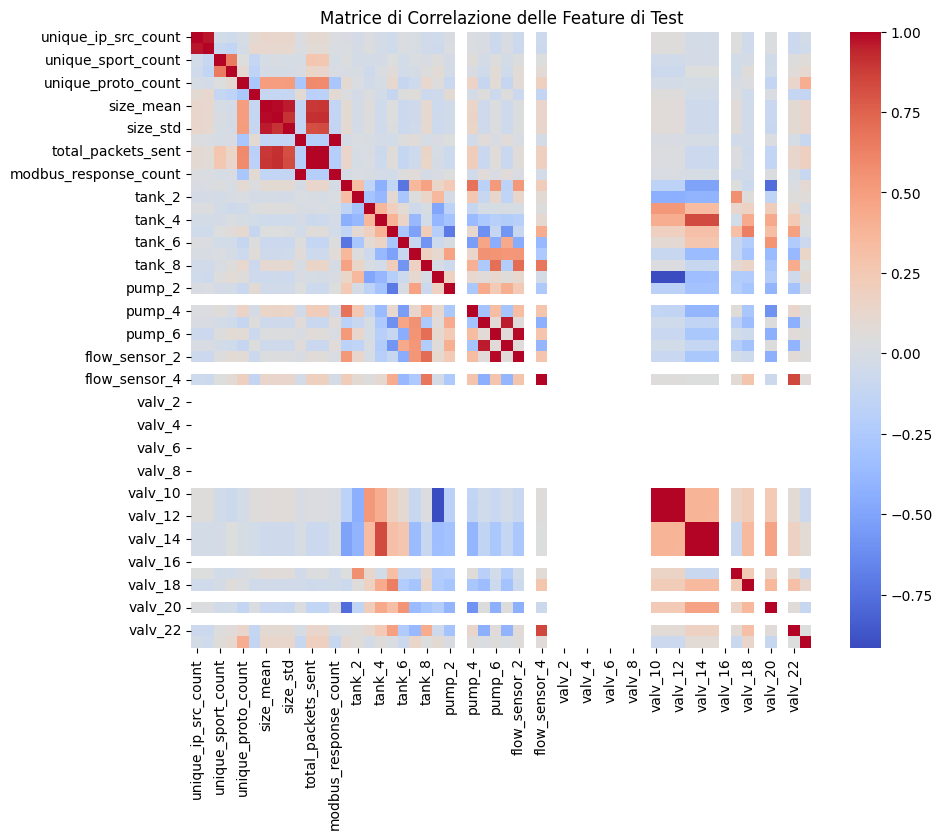

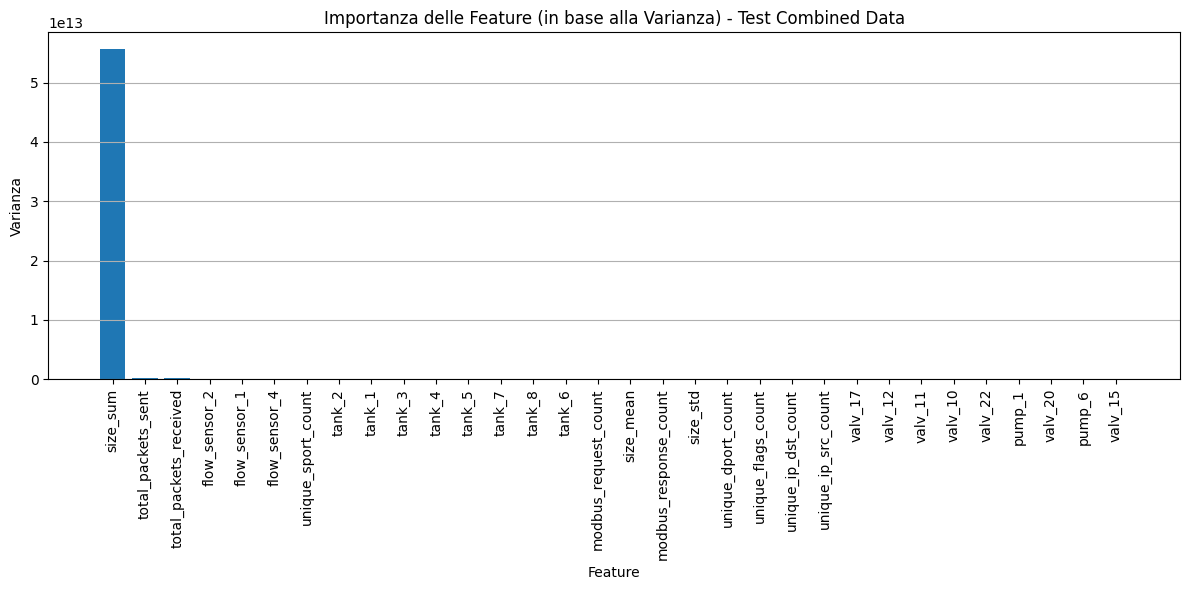

Feature altamente correlate (correlazione > 0.9):
unique_ip_src_count - unique_ip_dst_count: 0.96
unique_ip_dst_count - unique_ip_src_count: 0.96
size_mean - size_sum: 0.99
size_mean - size_std: 0.96
size_mean - total_packets_received: 0.90
size_sum - size_mean: 0.99
size_sum - size_std: 0.91
size_sum - total_packets_sent: 0.91
size_sum - total_packets_received: 0.92
size_std - size_mean: 0.96
size_std - size_sum: 0.91
modbus_request_count - modbus_response_count: 1.00
total_packets_sent - size_sum: 0.91
total_packets_sent - total_packets_received: 1.00
total_packets_received - size_mean: 0.90
total_packets_received - size_sum: 0.92
total_packets_received - total_packets_sent: 1.00
modbus_response_count - modbus_request_count: 1.00
pump_1 - valv_10: -0.92
pump_1 - valv_11: -0.91
pump_1 - valv_12: -0.91
pump_5 - flow_sensor_1: 0.96
pump_6 - flow_sensor_2: 0.99
flow_sensor_1 - pump_5: 0.96
flow_sensor_2 - pump_6: 0.99
valv_10 - pump_1: -0.92
valv_10 - valv_11: 1.00
valv_10 - valv_12: 1.0

In [21]:
# Visualizzazione della matrice di correlazione e importanza delle feature
print("\nAnalisi del dataset combinato di test...")

print("Feature attualmente nel dataset combinato di test:")
print(test_combined_data.columns.tolist())

# Matrice di correlazione
plt.figure(figsize=(10, 8))
correlation_matrix = test_combined_data.corr(numeric_only=True)  # Considera solo colonne numeriche
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Matrice di Correlazione delle Feature di Test')
plt.show()

# Importanza delle feature basata sulla varianza
feature_variances = test_combined_data.var(numeric_only=True).sort_values(ascending=False)

# Plot delle feature più importanti
num_features_to_plot = min(32, len(feature_variances))
top_features = feature_variances.index[:num_features_to_plot]
top_importances = feature_variances.values[:num_features_to_plot]

plt.figure(figsize=(12, 6))
plt.bar(range(num_features_to_plot), top_importances, align='center')
plt.xticks(range(num_features_to_plot), top_features, rotation=90)
plt.title('Importanza delle Feature (in base alla Varianza) - Test Combined Data')
plt.xlabel('Feature')
plt.ylabel('Varianza')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Definisci un insieme di feature protette che non devono mai essere rimosse
protected_features = {'size_sum'}

# Soglia per considerare due feature come altamente correlate
correlation_threshold = 0.9

# Calcola la matrice di correlazione
correlation_matrix = test_combined_data.corr(numeric_only=True)

# Trova le coppie di feature con correlazione sopra la soglia
high_correlation_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > correlation_threshold
]

# Stampa le coppie di feature altamente correlate
print("Feature altamente correlate (correlazione > 0.9):")
for col1, col2, corr_value in high_correlation_pairs:
    print(f"{col1} - {col2}: {corr_value:.2f}")

Visualizziamo la varianza delle feature rimanenti.

In [22]:
features_to_remove = [
    'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7',
    'valv_8', 'valv_9', 'valv_16', 'valv_19', 'valv_21', 'flow_sensor_3', 'pump_3',
    'unique_flags_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'valv_11',
    'total_packets_sent', 'total_packets_received', 'pump_2', 'valv_13', 'size_mean',
    'pump_4', 'tank_1', 'valv_10', 'valv_14', 'tank_3', 'tank_2', 'valv_22',
    'modbus_response_count', 'tank_6', 'tank_7', 'unique_dport_count',
    'valv_20', 'pump_5', 'modbus_request_count', 'valv_18', 'pump_1'
]

train_combined_data.drop(columns=features_to_remove, errors='ignore', inplace=True)
test_combined_data.drop(columns=features_to_remove, errors='ignore', inplace=True)

# Separazione delle feature
features = list(set(train_combined_data.columns) - {'label'})
features.sort()


# Importanza delle feature rimaste basata sulla varianza
remaining_feature_variances = train_combined_data[features].var(numeric_only=True).sort_values(ascending=False)

# Stampa l'importanza delle feature rimaste
print("\nImportanza delle feature rimaste (basata sulla varianza):")
print(remaining_feature_variances)

# Plot delle feature rimaste ordinate per importanza
num_features_to_plot = min(20, len(remaining_feature_variances))
top_remaining_features = remaining_feature_variances.index[:num_features_to_plot]
top_remaining_importances = remaining_feature_variances.values[:num_features_to_plot]

plt.figure(figsize=(12, 6))
plt.bar(range(num_features_to_plot), top_remaining_importances, align='center')
plt.xticks(range(num_features_to_plot), top_remaining_features, rotation=90)
plt.title('Importanza delle Feature Rimaste (in base alla Varianza)')
plt.xlabel('Feature')
plt.ylabel('Varianza')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


Importanza delle feature rimaste (basata sulla varianza):
size_sum              1.123073e+07
flow_sensor_2         3.881225e+06
flow_sensor_1         3.845760e+06
flow_sensor_4         3.489341e+06
tank_4                1.368029e+05
tank_5                7.371902e+04
tank_8                3.389070e+04
unique_sport_count    2.426642e+00
valv_15               2.500498e-01
valv_17               2.480376e-01
pump_6                2.426774e-01
valv_12               2.118516e-01
size_std              1.616716e-02
unique_proto_count    1.458149e-03
dtype: float64


Elimino le feature con bassa varianza.

### Data Cleaning e Normalizzazione

In [27]:
# Rimozione di colonne di tipo datetime
datetime_cols = train_combined_data.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
train_combined_data.drop(columns=datetime_cols, inplace=True, errors='ignore')
test_combined_data.drop(columns=datetime_cols, inplace=True, errors='ignore')

# Separazione delle feature e normalizzazione
features = list(set(train_combined_data.columns) - {'label'})
features.sort()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_combined_data[features].values)
X_test = scaler.transform(test_combined_data[features].values)

# Separazione del target
y_train = train_combined_data['label'].values
y_test = test_combined_data['label'].values

print("Colonne di train_with_time:", train_with_time.columns.tolist())
print("Colonne di test_with_time:", test_with_time.columns.tolist())


KeyError: "['flow_sensor_3', 'modbus_request_count', 'modbus_response_count', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'size_mean', 'tank_1', 'tank_2', 'tank_3', 'tank_6', 'tank_7', 'total_packets_received', 'total_packets_sent', 'unique_dport_count', 'unique_flags_count', 'unique_ip_dst_count', 'unique_ip_src_count', 'valv_1', 'valv_10', 'valv_11', 'valv_13', 'valv_14', 'valv_16', 'valv_18', 'valv_19', 'valv_2', 'valv_20', 'valv_21', 'valv_22', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9'] not in index"

### Creazione di sequenze temporali

In [205]:
def create_sequences(data, labels, seq_length=95):
    sequences = []
    seq_labels = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i + seq_length]
        label_seq = labels[i:i + seq_length]
        if np.all(label_seq == label_seq[0]):
            sequences.append(seq)
            seq_labels.append(label_seq[0])
    return np.array(sequences), np.array(seq_labels)

# Creazione delle sequenze per il training (solo normali)
sequence_length = 95
normal_indices = np.where(y_train == 0)[0]
X_train_normal = X_train[normal_indices]
y_train_normal = y_train[normal_indices]
X_train_seq, y_train_seq = create_sequences(X_train_normal, y_train_normal, sequence_length)

# Creazione delle sequenze per il test
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Anomaly Detection

## Addestramento del VAE

### Definizione del VAE

Definiamo la classe VAE, le funzioni di sampling e i costruttori per l'encoder e il decoder.

In [206]:
# Definizione della funzione di campionamento
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Definizione della classe VAE
class VAE(Model):
    def __init__(self, encoder, decoder, alpha=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha  # Peso per la reconstruction loss
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed)) * inputs.shape[1] * inputs.shape[2]
        reconstruction_loss *= self.alpha

        # KL divergence
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5

        # Total loss
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return reconstructed

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

### Costruzione di Encoder-Decoder

Definiamo le funzioni per creare l'encoder e il decoder.

In [207]:
from tensorflow.keras.regularizers import l2

# Funzione per costruire l'encoder
def build_encoder(sequence_length, num_features, latent_dim=5):
    encoder_inputs = Input(shape=(sequence_length, num_features), name='encoder_input')
    x = Conv1D(8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(encoder_inputs)
    x = BatchNormalization()(x)
    x = LSTM(32, activation='tanh', return_sequences=False, kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.55)(x)
    z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=l2(1e-3))(x)
    z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=l2(1e-3))(x)
    return Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

# Funzione per costruire il decoder
def build_decoder(sequence_length, num_features, latent_dim=5):
    decoder_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = RepeatVector(sequence_length)(decoder_inputs)
    x = LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.55)(x)
    x = Conv1D(8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(x)
    decoder_outputs = Conv1D(num_features, kernel_size=3, activation='linear', padding='same', kernel_regularizer=l2(1e-3))(x)
    return Model(decoder_inputs, decoder_outputs, name='decoder')

### Costruzione del VAE

Creiamo l'encoder, il decoder e costruiamo il modello VAE.

In [208]:
# Parametri del modello
latent_dim = 5
num_features = X_train_seq.shape[2]

# Costruzione dell'encoder e del decoder
encoder = build_encoder(sequence_length, num_features, latent_dim)
decoder = build_decoder(sequence_length, num_features, latent_dim)

# Costruzione e compilazione del VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
vae.summary()

Model: "vae_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 5), (None, 5)]      │           5,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 95, 13)              │           5,965 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,895 (46.46 KB)

 Trainable params: 11,879 (46.40 KB)

 Non-trainable params: 16 (64.00 B)

### Addestramento del VAE

Addestriamo il VAE sui dati normali.

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - kl_loss: 0.2590 - reconstruction_loss: 556.6174 - total_loss: 556.8765 - val_kl_loss: 0.2569 - val_reconstruction_loss: 523.9413 - val_total_loss: 524.1982
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,reconstruction_loss,total_loss,val_kl_loss,val_reconstruction_loss,val_total_loss
  current = self.get_monitor_value(logs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - kl_loss: 0.3326 - reconstruction_loss: 517.2398 - total_loss: 517.5724 - val_kl_loss: 0.7173 - val_reconstruction_loss: 460.1857 - val_total_loss: 460.9030
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - kl_loss: 1.1810 - reconstruction_loss: 429.6191 - total_loss: 430.8000 - val_kl_loss: 3.0635 - val_reconstruction_loss: 329.3369 - val_total_loss: 332.4004
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - kl_loss: 3.9512 - reconstruction_loss: 298.4203 - total_loss: 302.3715 - val_kl_loss: 5.6673 - val_reconstruction_loss: 242.7351 - val_total_loss: 248.4024
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - kl_loss: 6.0163 - reconstruction_loss: 232.2236 - total_loss: 238.2399 - val_kl_loss: 6.2365 - val_reconstruction_loss: 215.2324 - val_total_loss: 221.4689
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - kl_loss: 6.3005 - reconstruction_loss: 210.4219 - total_loss: 216.7224 - val_kl_loss: 6.1385 - val_reconstruction

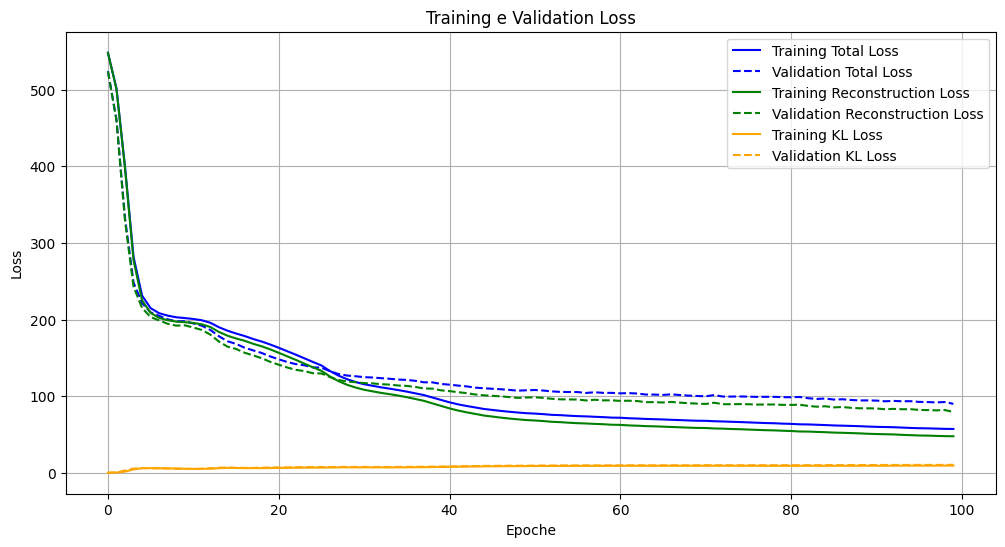

In [209]:
# Funzione per aggiungere rumore ai dati
def add_noise(data, noise_factor=0.01):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy_data, 0., 1.)

# Aggiunta di rumore ai dati di training
X_train_seq_noisy = add_noise(X_train_seq)

# Addestramento del modello
history = vae.fit(
    X_train_seq_noisy,
    X_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)

# Plot delle curve di perdita durante il training e la validation
plt.figure(figsize=(12, 6))

# Perdita totale
plt.plot(history.history['total_loss'], label='Training Total Loss', color='blue')
plt.plot(history.history['val_total_loss'], label='Validation Total Loss', color='blue', linestyle='--')

# Reconstruction Loss
plt.plot(history.history['reconstruction_loss'], label='Training Reconstruction Loss', color='green')
plt.plot(history.history['val_reconstruction_loss'], label='Validation Reconstruction Loss', color='green', linestyle='--')

# KL Divergence Loss
plt.plot(history.history['kl_loss'], label='Training KL Loss', color='orange')
plt.plot(history.history['val_kl_loss'], label='Validation KL Loss', color='orange', linestyle='--')

# Impostazioni del grafico
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Training e Validation Loss')
plt.legend()
plt.grid()
plt.show()

### Valutazione del VAE

Valutiamo il modello sul set di test.

In [210]:
# Predizioni sul training set
X_train_pred = vae.predict(X_train_seq)
train_mse = np.mean(np.power(X_train_seq - X_train_pred, 2), axis=(1, 2))

# Predizioni sul test set
X_test_pred = vae.predict(X_test_seq)
test_mse = np.mean(np.power(X_test_seq - X_test_pred, 2), axis=(1, 2))

# Calcolo della soglia ottimale utilizzando la curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test_seq, test_mse)
ap = average_precision_score(y_test_seq, test_mse)
fscore = (2 * precision * recall) / (precision + recall + 1e-10)
ix = np.argmax(fscore)
optimal_threshold = thresholds_pr[ix]

print(f"Soglia ottimale (F1 Score massimo): {optimal_threshold}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Soglia ottimale (F1 Score massimo): 0.6670671848030918


### Visualizzazione dei risultati

Visualizziamo i risultati della valutazione del VAE sul test set.

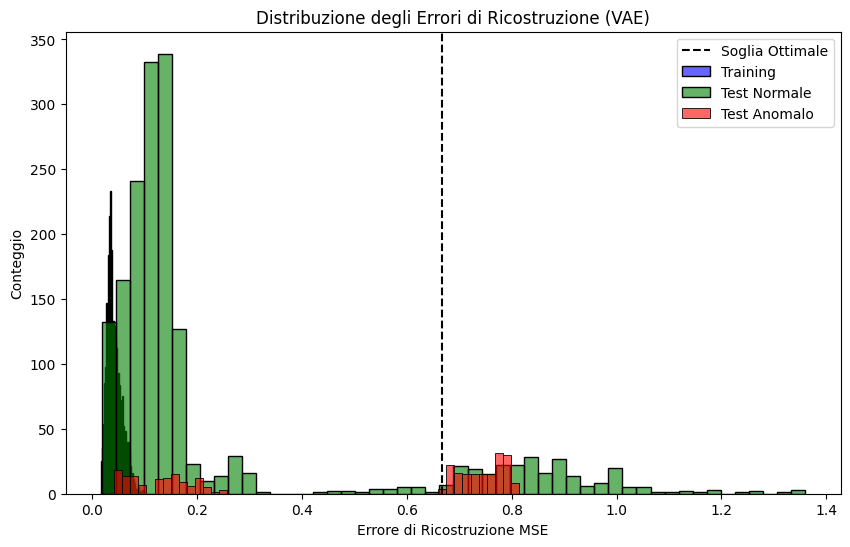

AUC Score: 0.714


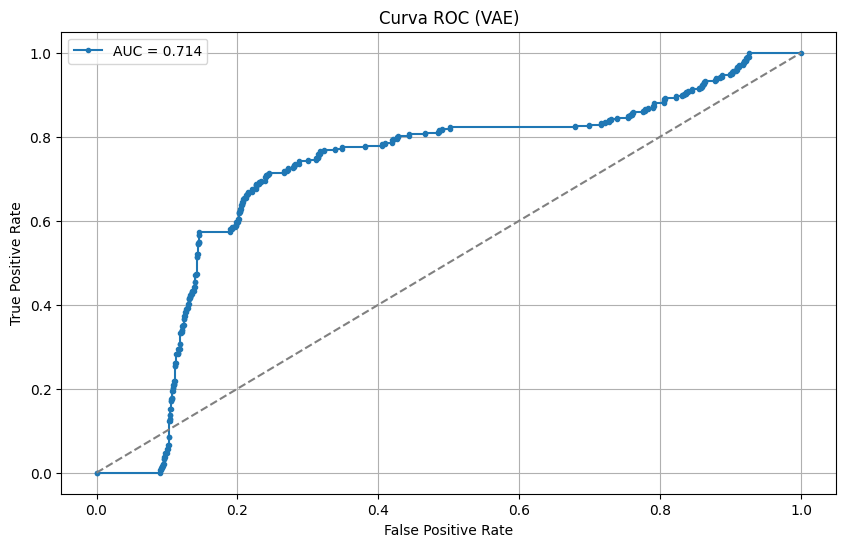


--- Valutazione con Soglia Ottimale (VAE) ---
              precision    recall  f1-score   support

     Normale       0.92      0.85      0.89      1705
     Anomalo       0.41      0.57      0.47       298

    accuracy                           0.81      2003
   macro avg       0.66      0.71      0.68      2003
weighted avg       0.84      0.81      0.82      2003



In [211]:
from sklearn.metrics import roc_auc_score, roc_curve

# Distribuzione degli errori di ricostruzione
plt.figure(figsize=(10, 6))
sns.histplot(train_mse, bins=50, color='blue', alpha=0.6, label='Training')
sns.histplot(test_mse[y_test_seq == 0], bins=50, color='green', alpha=0.6, label='Test Normale')
sns.histplot(test_mse[y_test_seq == 1], bins=50, color='red', alpha=0.6, label='Test Anomalo')
plt.axvline(optimal_threshold, color='black', linestyle='--', label='Soglia Ottimale')
plt.xlabel('Errore di Ricostruzione MSE')
plt.ylabel('Conteggio')
plt.title('Distribuzione degli Errori di Ricostruzione (VAE)')
plt.legend()
plt.show()

# Calcolo e stampa del valore AUC
auc_score = roc_auc_score(y_test_seq, test_mse)
print(f"AUC Score: {auc_score:.3f}")

# Plot della curva ROC
fpr, tpr, _ = roc_curve(y_test_seq, test_mse)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (VAE)')
plt.legend()
plt.grid()
plt.show()

# Classificazione basata sulla soglia ottimale
y_pred_optimal = (test_mse > optimal_threshold).astype(int)

# Valutazione delle prestazioni
print("\n--- Valutazione con Soglia Ottimale (VAE) ---")
print(classification_report(y_test_seq, y_pred_optimal, target_names=['Normale', 'Anomalo']))

# Anomaly Prediction

## Setup

In [1]:
# Importa le librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Caricamento del dataset

In [30]:
# Assicurati che le colonne 'time' siano in formato datetime
train_data = train_with_time
test_data = test_with_time
print("Colonne di train_with_time:", train_with_time.columns.tolist())
print("Colonne di test_with_time:", test_with_time.columns.tolist())

# Verifica che l'indice sia di tipo datetime
print("Tipo dell'indice di train_with_time:", train_with_time.index.dtype)
print("Tipo dell'indice di test_with_time:", test_with_time.index.dtype)

# Se l'indice non è di tipo datetime, convertilo
if not pd.api.types.is_datetime64_any_dtype(train_with_time.index):
    train_with_time.index = pd.to_datetime(train_with_time.index)
    print("Indice di train_with_time convertito in datetime.")

if not pd.api.types.is_datetime64_any_dtype(test_with_time.index):
    test_with_time.index = pd.to_datetime(test_with_time.index)
    print("Indice di test_with_time convertito in datetime.")

# Verifica che l'indice sia di tipo datetime
print("Tipo dell'indice di train_with_time:", train_with_time.index.dtype)
print("Tipo dell'indice di test_with_time:", test_with_time.index.dtype)

Colonne di train_with_time: ['unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'total_packets_received', 'modbus_response_count', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12', 'valv_13', 'valv_14', 'valv_15', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']
Colonne di test_with_time: ['unique_sport_count', 'unique_proto_count', 'size_sum', 'size_std', 'tank_4', 'tank_5', 'tank_8', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_4', 'valv_12', 'valv_15', 'valv_17', 'label']
Tipo dell'indice di trai

## Selezione delle feature e normalizzazione

In [31]:
# Seleziona la feature da modellare
feature = 'size_sum'

# Estrai la serie temporale
train_ts = train_data[[feature]]
test_ts = test_data[[feature]]

# Combina i dati di train e test per la normalizzazione
combined_ts = pd.concat([train_ts, test_ts])

# Applica la normalizzazione Min-Max
scaler = MinMaxScaler(feature_range=(0, 1))
combined_ts_scaled = scaler.fit_transform(combined_ts)

# Dividi nuovamente i dati normalizzati
train_size = len(train_ts)
train_scaled = combined_ts_scaled[:train_size]
test_scaled = combined_ts_scaled[train_size:]

## Creazione delle sequenze di training e test

In [33]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Definisci la lunghezza delle sequenze (numero di timesteps)
sequence_length = 60  # Puoi modificare questo valore

# Crea le sequenze per i dati di addestramento
X_train, y_train = create_sequences(train_scaled, sequence_length)

# Crea le sequenze per i dati di test
X_test, y_test = create_sequences(test_scaled, sequence_length)

## Costruzione modello LSTM

In [36]:
# Definisci il modello LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compila il modello
model.compile(optimizer='adam', loss='mean_squared_error')

# Addestra il modello
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - loss: 4.0210e-05 - val_loss: 1.0865e-08
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - loss: 1.7050e-08 - val_loss: 8.4938e-09
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 8.7424e-09 - val_loss: 5.8316e-09
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 3.9442e-09 - val_loss: 5.8712e-09
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 2.1223e-09 - val_loss: 5.7265e-09
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 1.2548e-09 - val_loss: 5.7766e-09
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 8.4691e-10 - val_loss: 5.8668e-09
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 5.9342e-10 - val_loss: 5.7852e-09
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 5.4033e-10 - val_loss: 5.7370e-09
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 4.3227e-10 - val_loss: 5.7280e-09
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 4.27

## Previsione sui dati di test

In [37]:
# Effettua le previsioni sui dati di test
y_pred = model.predict(X_test)

# Inverti la normalizzazione
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


## Rilevamento delle anomalie

In [38]:
# Calcola i residui
residuals = y_test_inverse - y_pred_inverse
residuals = residuals.flatten()

# Calcola i residui sui dati di addestramento per stabilire la soglia
train_pred = model.predict(X_train)
train_pred_inverse = scaler.inverse_transform(train_pred)
train_actual_inverse = scaler.inverse_transform(y_train)

train_residuals = train_actual_inverse - train_pred_inverse
train_residuals = train_residuals.flatten()

# Calcola la soglia
mean_residual = np.mean(train_residuals)
std_residual = np.std(train_residuals)
threshold = mean_residual + 3 * std_residual
print(f"Soglia per il rilevamento delle anomalie: {threshold}")

# Crea un array per le anomalie
anomalies = np.where(abs(residuals) > threshold, 1, 0)

106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
Soglia per il rilevamento delle anomalie: 7253.165738557871


## Valutazione del modello

In [39]:
# Ottieni le etichette reali corrispondenti ai dati di test
labels_test = test_data.iloc[sequence_length:]['label'].values

# Assicuriamoci che la dimensione delle etichette corrisponda a quella delle anomalie
labels_test = labels_test[:len(anomalies)]

# Genera il report di classificazione
print("Report di Classificazione:")
print(classification_report(labels_test, anomalies))

# Mostra la matrice di confusione
print("Matrice di Confusione:")
print(confusion_matrix(labels_test, anomalies))


Report di Classificazione:
              precision    recall  f1-score   support

           0       0.75      0.96      0.85      5354
           1       0.66      0.18      0.29      2064

    accuracy                           0.75      7418
   macro avg       0.71      0.57      0.57      7418
weighted avg       0.73      0.75      0.69      7418

Matrice di Confusione:
[[5164  190]
 [1688  376]]


## Visualizzazione dei risultati

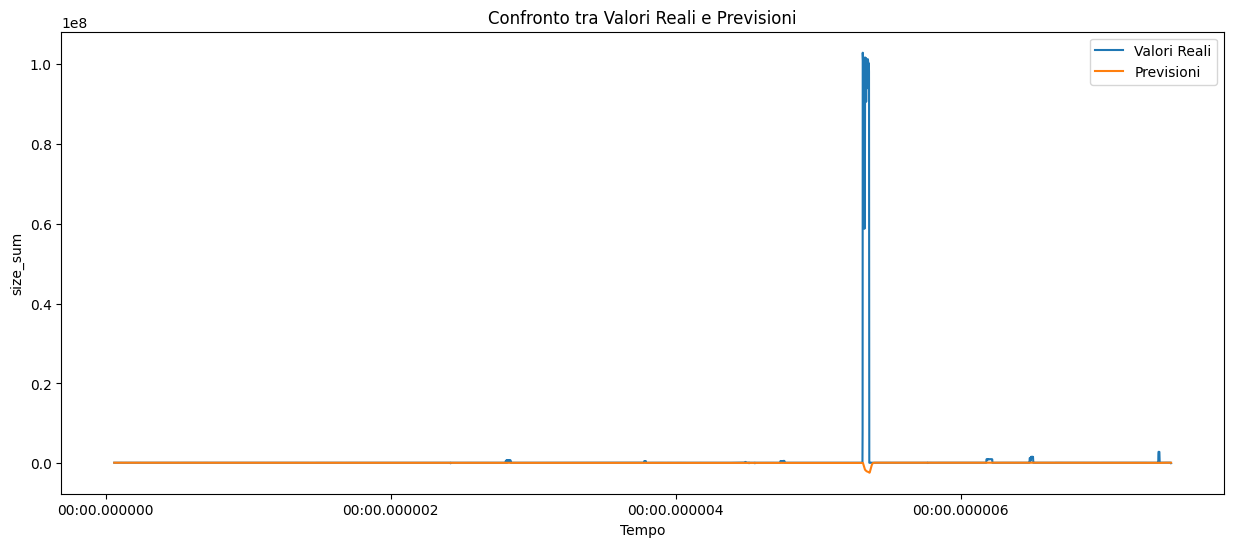

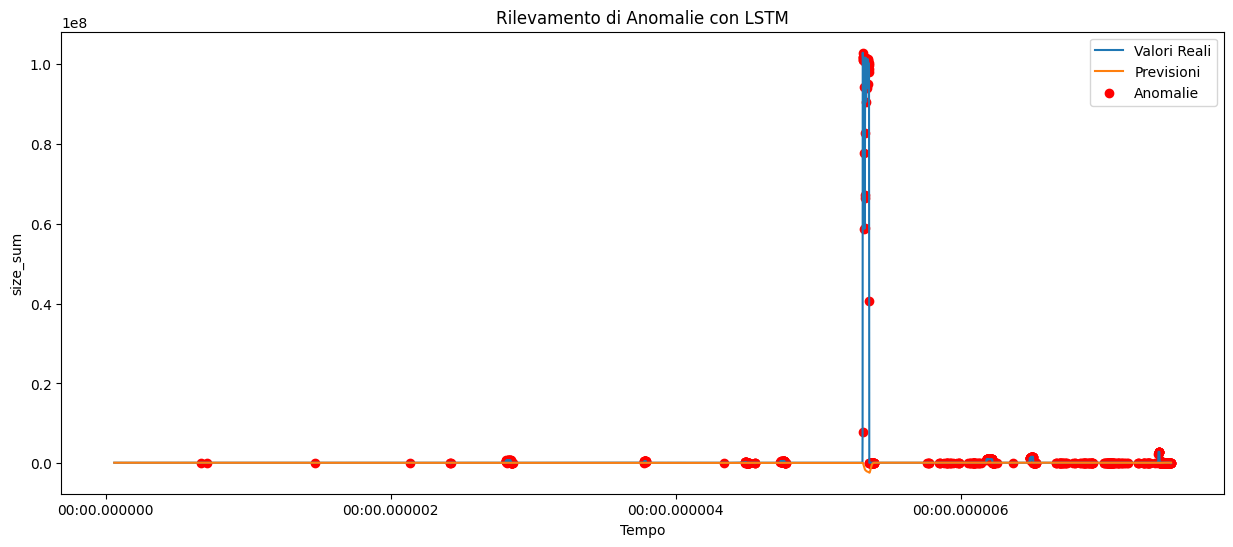

In [41]:
plt.figure(figsize=(15, 6))
plt.plot(test_data.index[sequence_length:], y_test_inverse, label='Valori Reali')
plt.plot(test_data.index[sequence_length:], y_pred_inverse, label='Previsioni')
plt.title('Confronto tra Valori Reali e Previsioni')
plt.xlabel('Tempo')
plt.ylabel(feature)
plt.legend()
plt.show()

# Crea un DataFrame per facilitare la visualizzazione
results = pd.DataFrame({
    'time': test_data.index[sequence_length:],
    'actual': y_test_inverse.flatten(),
    'prediction': y_pred_inverse.flatten(),
    'residual': residuals,
    'anomaly': anomalies
})
results.set_index('time', inplace=True)

# Visualizza le anomalie sulla serie temporale
plt.figure(figsize=(15, 6))
plt.plot(results.index, results['actual'], label='Valori Reali')
plt.plot(results.index, results['prediction'], label='Previsioni')
plt.scatter(results.index[results['anomaly'] == 1], results['actual'][results['anomaly'] == 1], color='red', label='Anomalie')
plt.title('Rilevamento di Anomalie con LSTM')
plt.xlabel('Tempo')
plt.ylabel(feature)
plt.legend()
plt.show()
